# Instacart Customer Segments EDA

**Background**

Instacart is a grocery ordering and delivery app that aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.

Instacart has:
- 100s of retailers
- 10,000s of stores
- 10,000s of shoppers
- 1,00,000s of products
- 100,000,000s of items

Instacart's data science team uses transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session.

(https://tech.instacart.com/predicting-real-time-availability-of-200-million-grocery-items-in-us-canada-stores-61f43a16eafe)

(https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)

**Data**

The dataset is a relational set of files describing customers' orders over time. The goal is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200K Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders.

(https://www.kaggle.com/c/instacart-market-basket-analysis)

**Possible problem**

Because Instacart does not have the logistics supply chain information for products, when an item that a customer adds to the cart is unavailable in store, it costs every stakeholder in Instacart's marketplace. Shoppers waste time searching for an unavailable item, customers can't buy what they want, and retail partners lose out on revenue.

By proactively and accurately predicting customers' buying behavior, Instacart can use this information to match and search through their availability prediction model of whether a certain item out of the 200 million grocery items is available in real-time and make appropriate recommendations to the customer for the out-of-stock item(s) if applicable.

**Possible prediction tasks**
- Products that a user will buy again
- Products that a user will try for the first time
- Products that a user will add to cart next during a session
- Products that a user will buy together
- Time that a user will make the next purchase

In [1]:
import pandas as pd
import numpy as np
import scipy as sc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Load data

- `orders` (3.4m rows, 206k users):
    - `order_id`: order identifier
    - `user_id`: customer identifier
    - `eval_set`: which evaluation set this order belongs in (see SET described below)
    - `order_number`: the order sequence number for this user (1 = first, n = nth)
    - `order_dow`: the day of the week the order was placed on
    - `order_hour_of_day`: the hour of the day the order was placed on
    - `days_since_prior_order`: days since the last order, capped at 30 (with NAs for order_number = 1)
    
    
- `products` (50k rows):
    - `product_id`: product identifier
    - `product_name`: name of the product
    - `aisle_id`: foreign key
    - `department_id`: foreign key


- `aisles` (134 rows):
    - `aisle_id`: aisle identifier
    - `aisle`: the name of the aisle
    
    
- `departments` (21 rows):
    - `department_id`: department identifier
    - `department`: the name of the department
    
    
- `order_products__SET` (30m+ rows):
    - `order_id`: foreign key
    - `product_id`: foreign key
    - `add_to_cart_order`: order in which each product was added to cart
    - `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise
    
   
    where SET is one of the three following evaluation sets (eval_set in orders):
         - "prior": orders prior to that users most recent order (~3.2m orders)
         - "train": training data supplied to participants (~131k orders)
         - "test": test data reserved for machine learning competitions (~75k orders)

In [2]:
# read in the data from a list of csv file names
filenames = ['aisles', 'departments', 'order_products__prior', 'order_products__train', 'orders', 'products', 'sample_submission']

dfs = []
csv_files = [f +'.csv' for f in filenames]
for csv in csv_files:
    dfs.append(pd.read_csv(csv))

In [3]:
# create a separate variable for each of the dataframes read in from the csv 
for x, y in zip(filenames, dfs):
    globals()[x] = y

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


# Clean the Data

Let's look at the column names to decide how to merge the six different data frames.

In [10]:
aisles_col = aisles.columns.tolist()
depart_col = departments.columns.tolist()
prod_col = products.columns.tolist()
order_prod_prior_col = order_products__prior.columns.tolist()
order_prod_train_col = order_products__train.columns.tolist()
orders_col = orders.columns.tolist()

print('aisles')
print(aisles_col)
print('\ndepartments')
print(depart_col)
print('\nproducts')
print(prod_col)
print('\norder products prior')
print(order_prod_prior_col)
print('\norder_products_train')
print(order_prod_train_col)
print('\norders')
print(orders_col)

aisles
['aisle_id', 'aisle']

departments
['department_id', 'department']

products
['product_id', 'product_name', 'aisle_id', 'department_id']

order products prior
['order_id', 'product_id', 'add_to_cart_order', 'reordered']

order_products_train
['order_id', 'product_id', 'add_to_cart_order', 'reordered']

orders
['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']


## Combining the Data

### Goods Data Frame of the Products and Their Information

In [11]:
goods = products.merge(aisles, on='aisle_id', how='left').merge(departments, on='department_id', how='left')
goods.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [12]:
print('There are {} unique products, {} aisles, and {} departments.'.format(goods['product_id'].nunique(),
                                                                            goods['aisle'].nunique(),
                                                                            goods['department'].nunique()))

There are 49688 unique products, 134 aisles, and 21 departments.


### Orders Data Frame: Prior, Train, and Test

The "orders" Data Frame consists of three evaluation sets (prior, train, and test) as shown below. The last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products__prior data frame.

In [13]:
prior = orders[orders['eval_set']=='prior']
train = orders[orders['eval_set']=='train']
test = orders[orders['eval_set']=='test']

In [14]:
eval_set_order = orders.groupby('eval_set')['order_id'].nunique().reset_index(name='num_of_orders')
eval_set_order['perc'] = eval_set_order['num_of_orders']/eval_set_order['num_of_orders'].sum()
eval_set_order

,eval_set,num_of_orders,perc
0,prior,3214874,0.939724
1,test,75000,0.021923
2,train,131209,0.038353


Text(0,0.5,'Percentage')

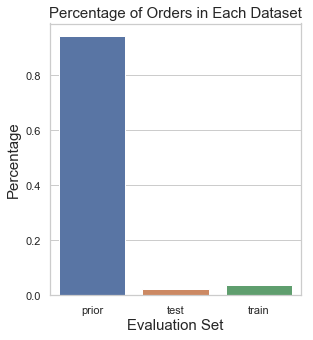

In [15]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(4, 5))
sns.barplot(x=eval_set_order['eval_set'], y=eval_set_order['perc'])

plt.title('Percentage of Orders in Each Dataset', fontsize=15)
plt.xlabel('Evaluation Set', fontsize=15)
plt.ylabel('Percentage', fontsize=15)

In [16]:
eval_set_user = orders.groupby('eval_set')['user_id'].nunique().reset_index(name='num_of_users')
eval_set_user['perc'] = eval_set_user['num_of_users']/eval_set_user['num_of_users'].sum()
eval_set_user

,eval_set,num_of_users,perc
0,prior,206209,0.500000
1,test,75000,0.181854
2,train,131209,0.318146


Text(0,0.5,'Percentage')

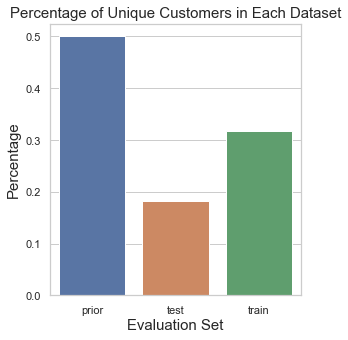

In [17]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(4, 5))
sns.barplot(x=eval_set_user['eval_set'], y=eval_set_user['perc'])

plt.title('Percentage of Unique Customers in Each Dataset', fontsize=15)
plt.xlabel('Evaluation Set', fontsize=15)
plt.ylabel('Percentage', fontsize=15)

There are 206209 customers total. The prior set contains the prior orders of the users. The last purchase of 131209 customers are in the train set, while the rest (75,000) of the customers need to be predicted on.

In [18]:
orders_products_prior = order_products__prior.merge(goods, on='product_id', how='left')
orders_products_prior = orders_products_prior.drop(['product_id', 'aisle_id', 'department_id'], axis=1)

In [19]:
orders_products_train = order_products__train.merge(goods, on='product_id', how='left')
orders_products_train = orders_products_train.drop(['product_id', 'aisle_id', 'department_id'], axis=1)

In [20]:
dow_order = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
dow = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
orders['order_dow'] = orders['order_dow'].map(dow_order).astype('category', categories=dow, ordered=True)

### Data Frames for Prediction Models

In [21]:
prior_data = orders.merge(orders_products_prior, on='order_id', how='right')
prior_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle,department
0,2539329,1,prior,1,Tuesday,8,NaN,1,0,Soda,soft drinks,beverages
1,2539329,1,prior,1,Tuesday,8,NaN,2,0,Organic Unsweetened Vanilla Almond Milk,soy lactosefree,dairy eggs
2,2539329,1,prior,1,Tuesday,8,NaN,3,0,Original Beef Jerky,popcorn jerky,snacks
3,2539329,1,prior,1,Tuesday,8,NaN,4,0,Aged White Cheddar Popcorn,popcorn jerky,snacks
4,2539329,1,prior,1,Tuesday,8,NaN,5,0,XL Pick-A-Size Paper Towel Rolls,paper goods,household


In [22]:
train_data = orders.merge(orders_products_train, on='order_id', how='right')
train_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle,department
0,1187899,1,train,11,Thursday,8,14.0,1,1,Soda,soft drinks,beverages
1,1187899,1,train,11,Thursday,8,14.0,2,1,Organic String Cheese,packaged cheese,dairy eggs
2,1187899,1,train,11,Thursday,8,14.0,3,1,0% Greek Strained Yogurt,yogurt,dairy eggs
3,1187899,1,train,11,Thursday,8,14.0,4,1,XL Pick-A-Size Paper Towel Rolls,paper goods,household
4,1187899,1,train,11,Thursday,8,14.0,5,1,Milk Chocolate Almonds,candy chocolate,snacks


In [23]:
len(orders), len(prior), len(train), len(test), len(orders_products_prior), len(orders_products_train)

(3421083, 3214874, 131209, 75000, 32434489, 1384617)

## Understanding the Data

In [24]:
orders.dtypes

order_id                     int64
user_id                      int64
eval_set                    object
order_number                 int64
order_dow                 category
order_hour_of_day            int64
days_since_prior_order     float64
dtype: object

### Null Values

In [25]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [26]:
first_time = orders[(orders['order_number']==1) & (orders['days_since_prior_order'].isnull())]
len(orders[(orders['order_number']==1)]) == len(orders[orders['days_since_prior_order'].isnull()]) == 206209

True

**The *orders* and *data* datasets are very clean with only NA values in the `days_since_prior_order` column. This column contains NA values because those respective customers are shopping at Instacart for the first time (`order_number` = 1). Customers with a `days_since_prior_order` value of 0 have made a purchase earlier that same day.**

In [27]:
goods.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
aisle            0
department       0
dtype: int64

### Outliers

In [28]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Descriptive statistics for the non-nominal numerical features of the orders dataset
orders.describe().drop(['user_id', 'order_id'], axis=1)

,order_number,order_hour_of_day,days_since_prior_order
count,3421083.00,3421083.00,3214874.00
mean,17.15,13.45,11.11
std,17.73,4.23,9.21
min,1.00,0.00,0.00
25%,5.00,10.00,4.00
50%,11.00,13.00,7.00
75%,23.00,16.00,15.00
max,100.00,23.00,30.00


**`add_to_cart_order`**:
- **The average number of items in a cart is about 8**
- **The minimum cart size is 1**
- **The maximum cart size is 145**
- **The median cart size is 6, which means that the data for this column is right skewed because the median is less than the mean**

**`reordered`:**
- **59% of the time products were reordered**

**`order_number`:**
- **The least number of orders a customer placed is 1**
- **The average customer placed 17 orders**
- **Half the customers placed less than 11 orders or less while the other half placed 11 orders or more**
- **the most number of orders placed by a customer is 100**
- **The distribution is slightly right skewed (mean > median)**

**`order_hour_of_day`:**
- **On average, orders were placed between 1-2 PM (13.43)**
- **Half the orders were placed on or before 1 PM, while the other half on or after 1 PM**

**`days_since_prior_order`**:
- **Because this feature is capped at 30 days, the maximum is 30**
- **Because customers can place more than one order a day, the minimum is 0**
- **On average, the previous order was placed roughly 11 days ago**
- **Half the orders were placed 8 or less days ago, while the other half were placed 8 or more days ago**

**Let's see how many users have placed 100 orders on Instacart.**

In [29]:
max_order_users = orders.loc[orders['order_number'] == 100]
print('There are {} users who have made 100 orders on Instacart.'.format(len(max_order_users)))

There are 1374 users who have made 100 orders on Instacart.


**There are no descriptive statistics for the goods dataset because the features are either non-nominal numerical or categorical.**

# Exploratory Data Analysis

In [30]:
orders.columns.tolist()

['order_id',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

In [31]:
goods.columns.tolist()

['product_id',
 'product_name',
 'aisle_id',
 'department_id',
 'aisle',
 'department']

In [32]:
# Column names of train_data and prior_data
prior_data.columns.tolist()

['order_id',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle',
 'department']

### How Many Orders Do Customers Place?

In [33]:
num_orders_user = orders.groupby('user_id')['order_number'].max().reset_index(name='num_of_orders')
num_orders_user.head()

,user_id,num_of_orders
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [35]:
orders = orders.merge(num_orders_user, on='user_id', how='left')

Text(0,0.5,'Frequency')

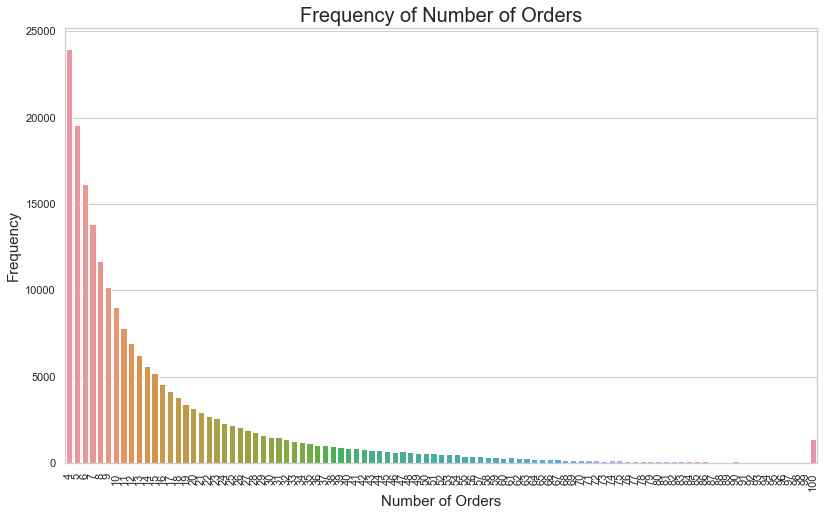

In [37]:
freq = num_orders_user.num_of_orders.value_counts()

sns.set_style('whitegrid')
plt.subplots(figsize=(12, 8))
plt.xticks(rotation='vertical')

sns.barplot(freq.index, freq.values)
plt.title('Frequency of Number of Orders', fontsize=20)
plt.xlabel('Number of Orders', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

**Most customers placed around 4-7 Instacart orders. There seems to be a bump at 100 orders because the dataset is capped at 4-100 orders; hence, 100+ orders are lumped into the 100 orders category. The orginal orders dataset contains users with 4-100 orders.**

Text(0.5,0,'Number of Orders')

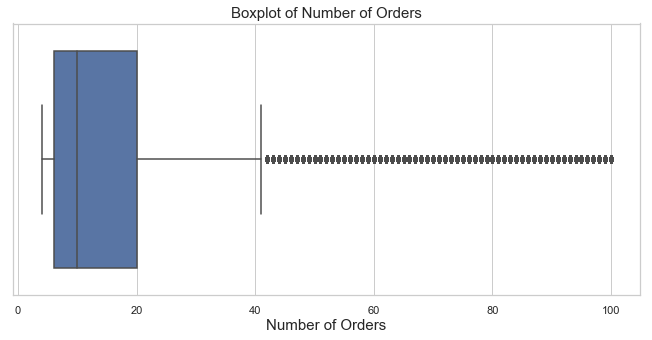

In [38]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))
sns.boxplot(x=num_orders_user['num_of_orders'])

plt.title('Boxplot of Number of Orders', fontsize=15)
plt.xlabel('Number of Orders', fontsize=15)

**A majority of the customers had approximately 4 to 40 orders. The median seems to be located at 10 orders, and the spread (Q3-Q1) of the middle 50% of the data is about 15. There are a number of outliers displayed as individual points beyond the upper whisker of the boxplot.**

### How Many Orders Do Customers Place by Day of Week?

In [39]:
orders_dow = orders.groupby('order_dow')['order_id'].nunique().reset_index(name='count')
orders_dow.head()

,order_dow,count
0,Sunday,600905
1,Monday,587478
2,Tuesday,467260
3,Wednesday,436972
4,Thursday,426339


Text(0,0.5,'Number of Orders')

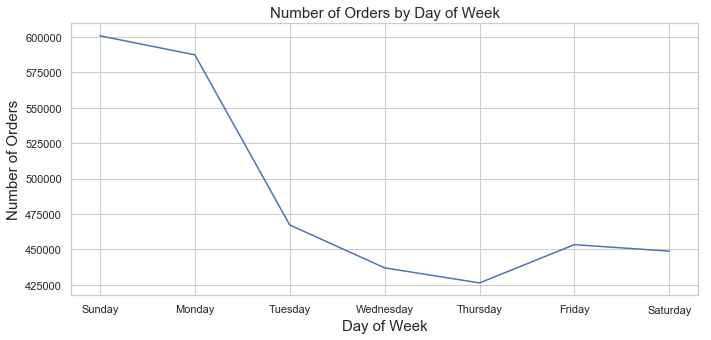

In [40]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=orders_dow['order_dow'], y=orders_dow['count'])

plt.title('Number of Orders by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)

**There are more orders placed early on in the week (Sunday, Monday, and Tuesday). This may be because users shop for groceries for the rest of the week. The number of orders decreases into the middle of the week and increases again as the weekend approaches, which may be because working families have more time to cook on the weekends.**

In [41]:
orders_dow = orders.groupby(['order_dow', 'order_hour_of_day'])['order_id'].nunique().reset_index(name='count')
orders_dow.head()

,order_dow,order_hour_of_day,count
0,Sunday,0,3936
1,Sunday,1,2398
2,Sunday,2,1409
3,Sunday,3,963
4,Sunday,4,813


Text(0,0.5,'Number of Orders')

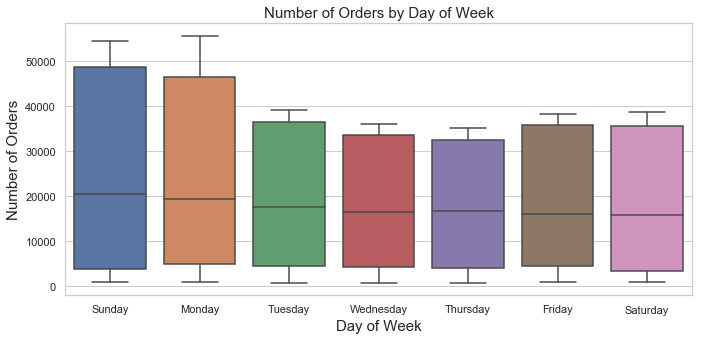

In [42]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=orders_dow['order_dow'], y=orders_dow['count'])

plt.title('Number of Orders by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)

**There is more spread for Sunday and Monday, but the median number of orders is fairly standard across the different days of the week at approximately 19000 orders.**

### How Many Orders Do Customers Place by Hour of Day?

In [43]:
orders_hod = orders.groupby('order_hour_of_day')['order_id'].nunique().reset_index(name='count')
orders_hod.head()

,order_hour_of_day,count
0,0,22758
1,1,12398
2,2,7539
3,3,5474
4,4,5527


Text(0,0.5,'Number of Orders')

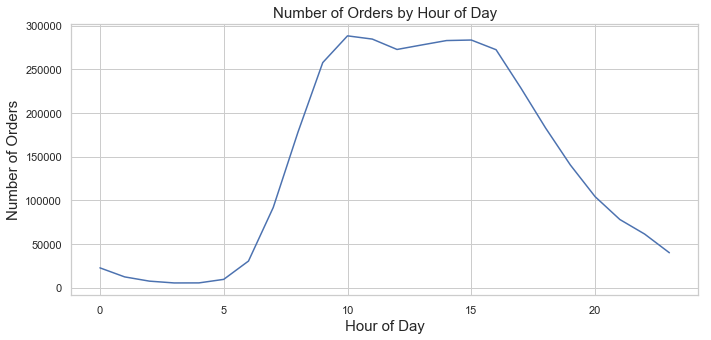

In [44]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=orders_hod['order_hour_of_day'], y=orders_hod['count'])

plt.title('Number of Orders by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)

**The number of orders are the highest at 10 AM and 3 PM. Users tend to order around noon as indicated by the rounded top of the peak. This might be because users are purchasing already made salads for lunchtime and groceries before dinner time. Hence, we observe that users don't usually order during or after dinner hours. The number of orders start plummeting after 4 PM. We observe few orders before midnight and between midnight and 6AM because not a lot of stores open until midnight and most stores don't open until 6 AM.**

In [45]:
orders_hod = orders.groupby(['order_hour_of_day', 'order_dow'])['order_id'].nunique().reset_index(name='count')
orders_hod.head()

,order_hour_of_day,order_dow,count
0,0,Sunday,3936
1,0,Monday,3674
2,0,Tuesday,3059
3,0,Wednesday,2952
4,0,Thursday,2642


Text(0,0.5,'Number of Orders')

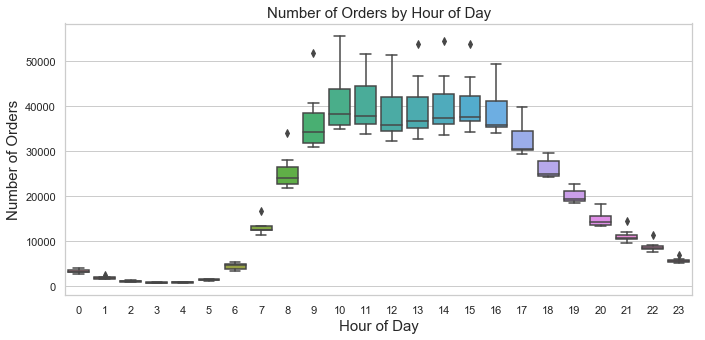

In [46]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=orders_hod['order_hour_of_day'], y=orders_hod['count'])

plt.title('Number of Orders by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)

**The median number of orders increases throughout the day until 4 PM, peaking around the late morning (10 AM - 11 PM) to early afternoon hours (1-3 PM). The spread also increases with the median because there are more orders rolling in and therefore more variability in the data than late in the evening or during the wee hours.**

### How Many Orders Do Customers Place by Day of Week vs. Hour of Day?

In [47]:
dow_vs_hod = orders.groupby(['order_dow', 'order_hour_of_day'])['order_id'].nunique().reset_index(name='count')
dow_vs_hod = dow_vs_hod.pivot('order_dow', 'order_hour_of_day', 'count')
dow_vs_hod.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
Sunday,3936,2398,1409,963,813,1168,3329,12410,28108,40798,48465,51035,51443,53849,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
Monday,3674,1830,1105,748,809,1607,5370,16571,34116,51908,55671,51584,47079,46728,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
Tuesday,3059,1572,943,719,744,1399,4758,13245,24635,36314,39230,38128,35780,36650,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
Wednesday,2952,1495,953,654,719,1355,4562,12396,22553,32312,36040,35215,33455,34161,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
Thursday,2642,1512,899,686,730,1330,4401,12493,21814,31409,35034,33857,32249,32751,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645


Text(34.0531,0.5,'Day of Week')

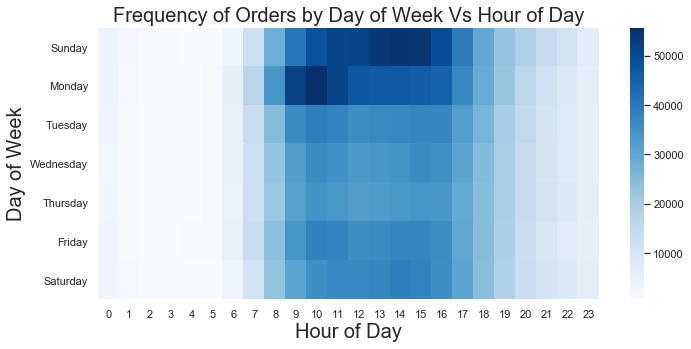

In [48]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 5))
sns.heatmap(dow_vs_hod, cmap='Blues')

plt.title('Frequency of Orders by Day of Week Vs Hour of Day', fontsize=20)
plt.xlabel('Hour of Day', fontsize=20)
plt.ylabel('Day of Week', fontsize=20)

**Most orders are placed between 10 AM - 4 PM on Sundays and 9 AM - 3 PM on Mondays. Customers also tend to place orders between 11 AM - 3 PM on Saturdays but at a lower frequency.**

### How Many Items are in the Orders?

In [49]:
num_items_order_prior = prior_data.groupby('order_id')['add_to_cart_order'].max().reset_index(name='num_of_items')
num_items_order_prior.head()

,order_id,num_of_items
0,2,9
1,3,8
2,4,13
3,5,26
4,6,3


In [50]:
num_items_order_train = train_data.groupby('order_id')['add_to_cart_order'].max().reset_index(name='num_of_items')
num_items_order_train.head()

,order_id,num_of_items
0,1,8
1,36,8
2,38,9
3,96,7
4,98,49


In [1]:
freq_prior = num_items_order_prior.num_of_items.value_counts()
freq_train = num_items_order_train.num_of_items.value_counts()

sns.set_style('whitegrid')
f, ax =plt.subplots(2, 1, figsize=(12, 12))
plt.xticks(rotation='vertical')
plt.subplots_adjust(hspace=0.3)

ax1 = sns.barplot(freq_prior.index, freq_prior.values, ax=ax[0])
ax1.set_title('Number of Items in an Order - Prior', fontsize=20)
ax1.set_xlabel('Number of Items', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)
ax1.tick_params(labelrotation=90)

ax2 = sns.barplot(freq_train.index, freq_train.values, ax=ax[1])
ax2.set_title('Number of Items in an Order - Train', fontsize=20)
ax2.set_xlabel('Number of Items', fontsize=20)
ax2.set_ylabel('Frequency', fontsize=20)

NameError: name 'num_items_order_prior' is not defined

**Most people, on average, have around 3-8 items in each transaction in both the prior and train datasets.**

(0, 150)

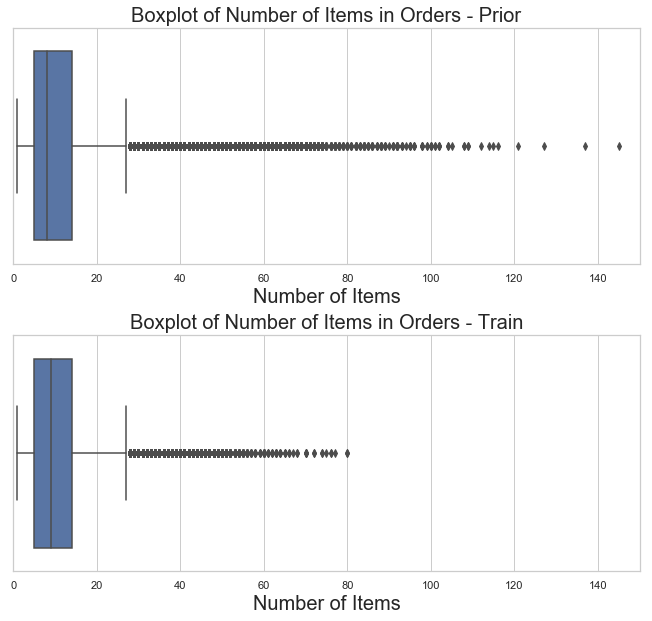

In [52]:
sns.set_style('whitegrid')
f, ax =plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

ax1 = sns.boxplot(x=num_items_order_prior['num_of_items'], ax=ax[0])
ax1.set_title('Boxplot of Number of Items in Orders - Prior', fontsize=20)
ax1.set_xlabel('Number of Items', fontsize=20)
ax1.set_xlim(0, 150)

ax2 = sns.boxplot(x=num_items_order_train['num_of_items'], ax=ax[1])
ax2.set_title('Boxplot of Number of Items in Orders - Train', fontsize=20)
ax2.set_xlabel('Number of Items', fontsize=20)
ax2.set_xlim(0, 150)

**The spread (Q3 - Q1 = ~10) of the middle 50% of the prior data is roughly the same as that of the train data. Both datasets are right skewed with a maximum of 145 (prior) and 80 (train) items in a single order. Most of the orders contain 1-30 products although there are quite a number of orders with more than 30 items displayed as outliers (individual points plotted beyond the upper whisker of the boxplot).**

### How Many Items Do Customers Order by Day of Week?

In [56]:
items_dow_prior = prior_data.groupby('order_dow')['product_name'].count().reset_index(name='count')
items_dow_prior.head()

,order_dow,count
0,Sunday,6209666
1,Monday,5665856
2,Tuesday,4217798
3,Wednesday,3844117
4,Thursday,3787215


In [57]:
items_dow_train = train_data.groupby('order_dow')['product_name'].count().reset_index(name='count')
items_dow_train.head()

,order_dow,count
0,Sunday,324026
1,Monday,205978
2,Tuesday,160562
3,Wednesday,154381
4,Thursday,155481


Text(0,0.5,'Number of Items')

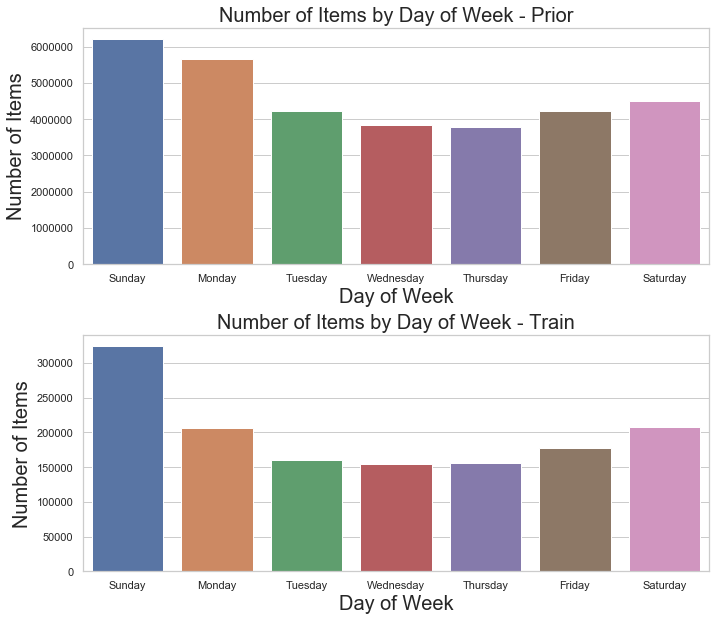

In [58]:
sns.set_style('whitegrid')
f, ax =plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

ax1 = sns.barplot(items_dow_prior['order_dow'], items_dow_prior['count'], ax=ax[0])
ax1.set_title('Number of Items by Day of Week - Prior', fontsize=20)
ax1.set_xlabel('Day of Week', fontsize=20)
ax1.set_ylabel('Number of Items', fontsize=20)

ax2 = sns.barplot(items_dow_train['order_dow'], items_dow_train['count'], ax=ax[1])
ax2.set_title('Number of Items by Day of Week - Train', fontsize=20)
ax2.set_xlabel('Day of Week', fontsize=20)
ax2.set_ylabel('Number of Items', fontsize=20)

**This is consistent with what we have been seeing: there are more orders placed during Monday and the weekends. Hence, there should be more items purchased on these days of the week.**

In [59]:
items_dow_prior = prior_data.groupby(['order_dow', 'order_hour_of_day'])['product_name'].count().reset_index(name='count')
items_dow_prior.head()

,order_dow,order_hour_of_day,count
0,Sunday,0,38876
1,Sunday,1,22523
2,Sunday,2,12725
3,Sunday,3,8851
4,Sunday,4,8372


In [60]:
items_dow_train = train_data.groupby(['order_dow', 'order_hour_of_day'])['product_name'].count().reset_index(name='count')
items_dow_train.head()

,order_dow,order_hour_of_day,count
0,Sunday,0,1568
1,Sunday,1,1124
2,Sunday,2,841
3,Sunday,3,524
4,Sunday,4,367


Text(0,0.5,'Number of Items')

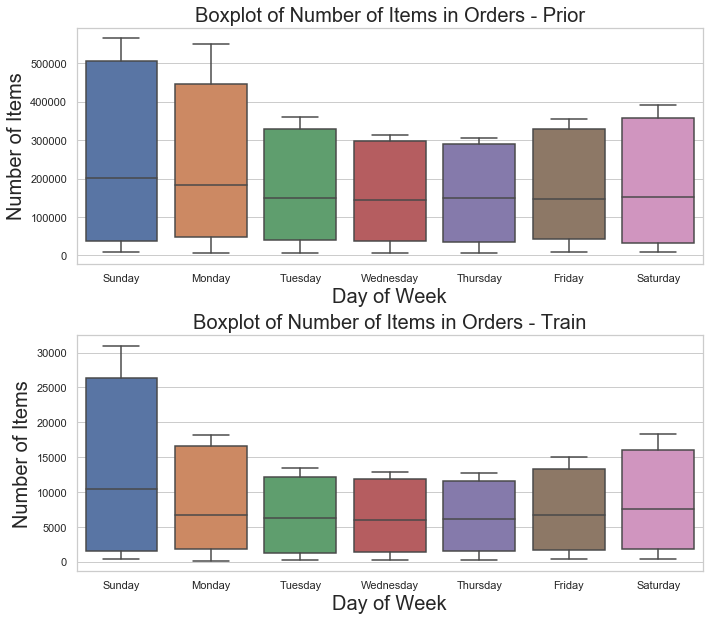

In [61]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

ax1 = sns.boxplot(items_dow_prior['order_dow'], items_dow_prior['count'], ax=ax[0])
ax1.set_title('Boxplot of Number of Items in Orders - Prior', fontsize=20)
ax1.set_xlabel('Day of Week', fontsize=20)
ax1.set_ylabel('Number of Items', fontsize=20)

ax2 = sns.boxplot(items_dow_train['order_dow'], items_dow_train['count'], ax=ax[1])
ax2.set_title('Boxplot of Number of Items in Orders - Train', fontsize=20)
ax2.set_xlabel('Day of Week', fontsize=20)
ax2.set_ylabel('Number of Items', fontsize=20)

**Again, there's more spread for Sunday and Monday and the trend for the length of the boxplots across the days of the week mirror the heights of the above barplots.**

### How Many Items Do Customers Order by Hour of Day?

In [67]:
items_hod_prior = prior_data.groupby('order_hour_of_day')['product_name'].count().reset_index(name='count')
items_hod_prior.head()

,order_hour_of_day,count
0,0,218948
1,1,115786
2,2,69434
3,3,51321
4,4,53283


In [68]:
items_hod_train = train_data.groupby('order_hour_of_day')['product_name'].count().reset_index(name='count')
items_hod_train.head()

,order_hour_of_day,count
0,0,9083
1,1,5626
2,2,3226
3,3,2438
4,4,2431


Text(0,0.5,'Number of Items')

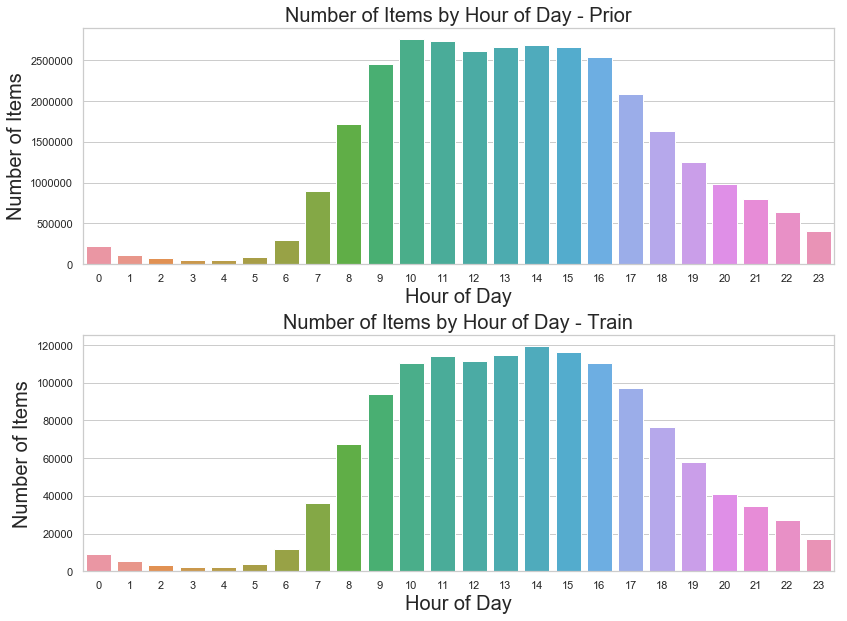

In [69]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)

ax1 = sns.barplot(items_hod_prior['order_hour_of_day'], items_hod_prior['count'], ax=ax[0])
ax1.set_title('Number of Items by Hour of Day - Prior', fontsize=20)
ax1.set_xlabel('Hour of Day', fontsize=20)
ax1.set_ylabel('Number of Items', fontsize=20)

ax2 = sns.barplot(items_hod_train['order_hour_of_day'], items_hod_train['count'], ax=ax[1])
ax2.set_title('Number of Items by Hour of Day - Train', fontsize=20)
ax2.set_xlabel('Hour of Day', fontsize=20)
ax2.set_ylabel('Number of Items', fontsize=20)

**The trend of the number of items purchased by hour of day is similar to that of the number of orders placed by hour of day. This is consistent with our intuition that the number of items purchased is directly proportional to the number of orders placed: the more orders placed, the more items purchased. However, the number of items purchased peak in the late afternoon for the train data as opposed to in the late morning in the prior data.**

In [70]:
items_hod_prior = prior_data.groupby(['order_hour_of_day', 'order_dow'])['product_name'].count().reset_index(name='count')
items_hod_prior.head()

,order_hour_of_day,order_dow,count
0,0,Sunday,38876
1,0,Monday,37114
2,0,Tuesday,29914
3,0,Wednesday,27525
4,0,Thursday,24719


In [71]:
items_hod_train = train_data.groupby(['order_hour_of_day', 'order_dow'])['product_name'].count().reset_index(name='count')
items_hod_train.head()

,order_hour_of_day,order_dow,count
0,0,Sunday,1568
1,0,Monday,1446
2,0,Tuesday,1043
3,0,Wednesday,988
4,0,Thursday,1021


Text(0,0.5,'Number of Items')

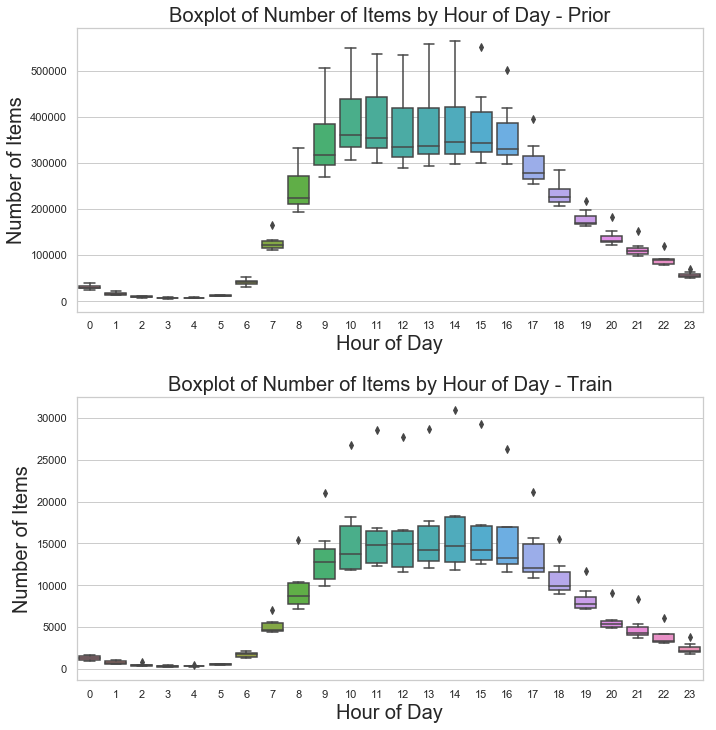

In [75]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(10, 12))
plt.subplots_adjust(hspace=0.3)

ax1 = sns.boxplot(items_hod_prior['order_hour_of_day'], items_hod_prior['count'], ax=ax[0])
ax1.set_title('Boxplot of Number of Items by Hour of Day - Prior', fontsize=20)
ax1.set_xlabel('Hour of Day', fontsize=20)
ax1.set_ylabel('Number of Items', fontsize=20)

ax2 = sns.boxplot(items_hod_train['order_hour_of_day'], items_hod_train['count'], ax=ax[1])
ax2.set_title('Boxplot of Number of Items by Hour of Day - Train', fontsize=20)
ax2.set_xlabel('Hour of Day', fontsize=20)
ax2.set_ylabel('Number of Items', fontsize=20)

**By no surprise, the overall trend of the boxplots of number of items purchased by hour of the day for the prior and train dataset resembles that of the number of orders placed by hour of the day. Likewise, the amount of variation for the hour of the day increases when there are more items purchased. However, there is more spread in the prior dataset, which may be because it has more data. On the other hand, the train dataset has less spread and more frequent and extreme outliers.**

### What Aisles are the Most Shopped at by Number of Orders?

In [76]:
aisle_num_ord_prior = prior_data.groupby('aisle')['order_id'].nunique().reset_index(name='count')
aisle_num_ord_prior['perc'] = aisle_num_ord_prior['count']*100/aisle_num_ord_prior['count'].sum()
aisle_num_ord_prior = aisle_num_ord_prior.sort_values('perc', ascending=False)
aisle_num_ord_prior.head()

,aisle,count,perc
50,fresh fruits,1790771,7.67
53,fresh vegetables,1427631,6.12
98,packaged vegetables fruits,1179243,5.05
133,yogurt,847081,3.63
83,milk,785987,3.37


In [77]:
aisle_num_ord_train = train_data.groupby('aisle')['order_id'].nunique().reset_index(name='count')
aisle_num_ord_train['perc'] = aisle_num_ord_train['count']*100/aisle_num_ord_train['count'].sum()
aisle_num_ord_train = aisle_num_ord_train.sort_values('perc', ascending=False)
aisle_num_ord_train.head()

,aisle,count,perc
50,fresh fruits,72178,7.29
53,fresh vegetables,59172,5.97
98,packaged vegetables fruits,50257,5.07
133,yogurt,33249,3.36
93,packaged cheese,31199,3.15


Text(0,0.5,'Percentage of Orders')

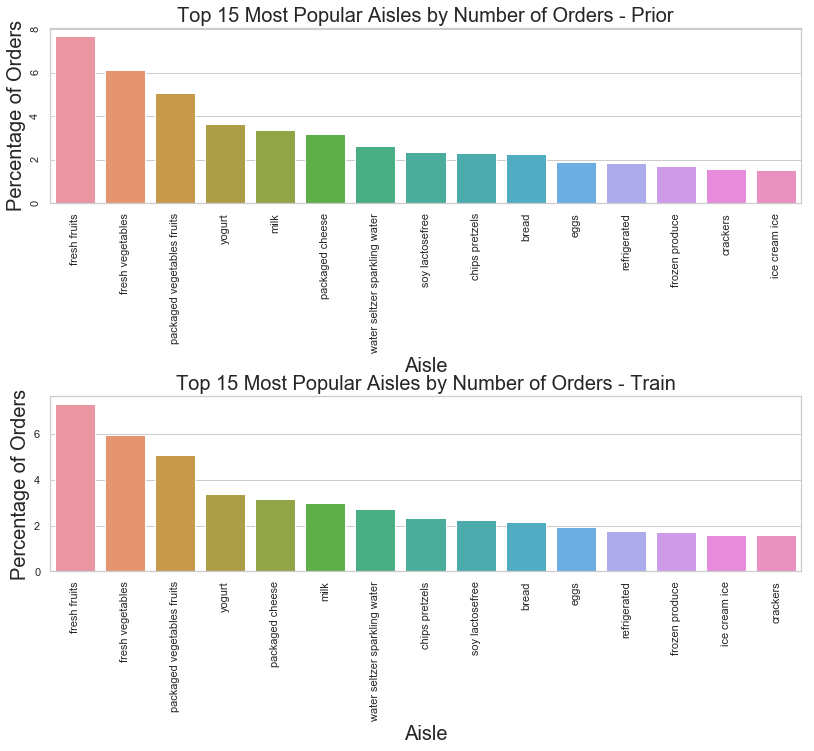

In [78]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(12, 10))
plt.xticks(rotation='vertical')
plt.subplots_adjust(hspace=1.1)

ax1 = sns.barplot(x=aisle_num_ord_prior['aisle'][:15], y=aisle_num_ord_prior['perc'][:15], ax=ax[0])
ax1.set_title('Top 15 Most Popular Aisles by Number of Orders - Prior', fontsize=20)
ax1.set_xlabel('Aisle', fontsize=20)
ax1.set_ylabel('Percentage of Orders', fontsize=20)
ax1.tick_params(labelrotation=90)

ax2 = sns.barplot(x=aisle_num_ord_train['aisle'][:15], y=aisle_num_ord_train['perc'][:15], ax=ax[1])
ax2.set_title('Top 15 Most Popular Aisles by Number of Orders - Train', fontsize=20)
ax2.set_xlabel('Aisle', fontsize=20)
ax2.set_ylabel('Percentage of Orders', fontsize=20)

**A significant proportion of orders contain items from the fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, milk, and cheese aisles.**

### What Aisles are the Most Shopped at by Number of Products?

In [79]:
aisle_num_prod_prior = prior_data.groupby('aisle')['product_name'].count().reset_index(name='count')
aisle_num_prod_prior['perc'] = aisle_num_prod_prior['count']*100/aisle_num_prod_prior['count'].sum()
aisle_num_prod_prior = aisle_num_prod_prior.sort_values('perc', ascending=False)
aisle_num_prod_prior.head()

,aisle,count,perc
50,fresh fruits,3642188,11.23
53,fresh vegetables,3418021,10.54
98,packaged vegetables fruits,1765313,5.44
133,yogurt,1452343,4.48
93,packaged cheese,979763,3.02


In [80]:
aisle_num_prod_train = prior_data.groupby('aisle')['product_name'].count().reset_index(name='count')
aisle_num_prod_train['perc'] = aisle_num_prod_train['count']*100/aisle_num_prod_train['count'].sum()
aisle_num_prod_train = aisle_num_prod_train.sort_values('perc', ascending=False)
aisle_num_prod_train.head()

,aisle,count,perc
50,fresh fruits,3642188,11.23
53,fresh vegetables,3418021,10.54
98,packaged vegetables fruits,1765313,5.44
133,yogurt,1452343,4.48
93,packaged cheese,979763,3.02


Text(0,0.5,'Percentage of Items')

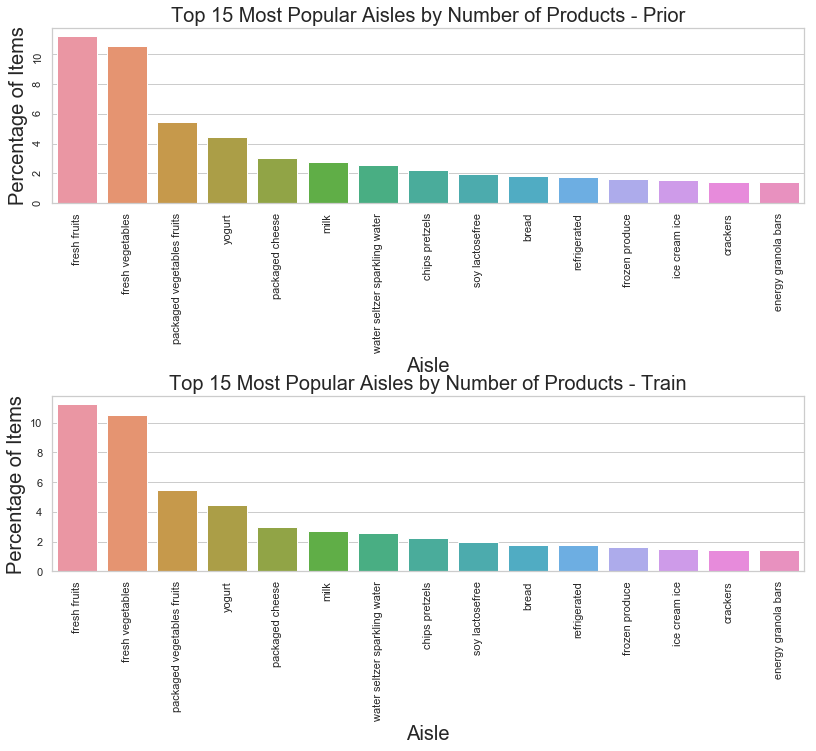

In [81]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(12, 10))
plt.xticks(rotation='vertical')
plt.subplots_adjust(hspace=1.1)

ax1 = sns.barplot(x=aisle_num_prod_prior['aisle'][:15], y=aisle_num_prod_prior['perc'][:15], ax=ax[0])
ax1.set_title('Top 15 Most Popular Aisles by Number of Products - Prior', fontsize=20)
ax1.set_xlabel('Aisle', fontsize=20)
ax1.set_ylabel('Percentage of Items', fontsize=20)
ax1.tick_params(labelrotation=90)

ax2 = sns.barplot(x=aisle_num_prod_train['aisle'][:15], y=aisle_num_prod_train['perc'][:15], ax=ax[1])
ax2.set_title('Top 15 Most Popular Aisles by Number of Products - Train', fontsize=20)
ax2.set_xlabel('Aisle', fontsize=20)
ax2.set_ylabel('Percentage of Items', fontsize=20)

**Pretty much the same 15 aisles from which the most orders are purchased from is observed for the aisles from which a large proportion of products are purchased, with the exception of the eggs aisles which have been replaced by granola bars. This makes sense because eggs are often bought in packs of half or one dozen whereas singular granola bars can be purchased.**

### What is the Size of the Departments?

Text(0.5,1,'Distribution of Departments')

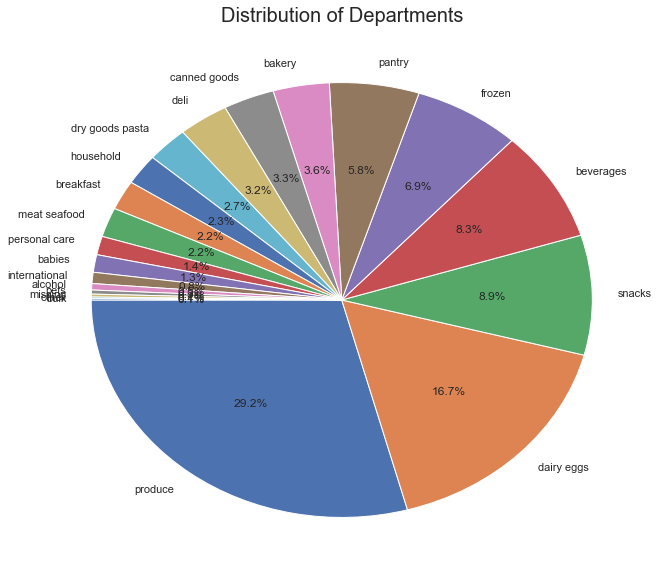

In [82]:
plt.figure(figsize=(10,10))

dept_cts = prior_data['department'].value_counts()
sizes = dept_cts*100/dept_cts.sum()

plt.pie(sizes, labels=dept_cts.index, autopct='%1.1f%%', startangle=180)
plt.title('Distribution of Departments', fontsize=20)

**The produce (29%), dairy eggs (17%), snacks (9%), beverages (8%), and frozen (7%) departments are the largest. Therefore, it is no surprise that more goods and orders are purchased from these departments' respective aisles.**

### What Departments are the Most Shopped at by Number of Orders?

In [83]:
dept_num_ord_prior = prior_data.groupby('department')['order_id'].nunique().reset_index(name='count')
dept_num_ord_prior['perc'] = dept_num_ord_prior['count']*100/dept_num_ord_prior['count'].sum()
dept_num_ord_prior = dept_num_ord_prior.sort_values('perc', ascending=False)
dept_num_ord_prior.head()

,department,count,perc
19,produce,2409320,15.82
7,dairy eggs,2177338,14.30
3,beverages,1457351,9.57
20,snacks,1391447,9.14
10,frozen,1181018,7.76


In [84]:
dept_num_ord_train = train_data.groupby('department')['order_id'].nunique().reset_index(name='count')
dept_num_ord_train['perc'] = dept_num_ord_train['count']*100/dept_num_ord_train['count'].sum()
dept_num_ord_train = dept_num_ord_train.sort_values('perc', ascending=False)
dept_num_ord_train.head()

,department,count,perc
19,produce,96927,15.14
7,dairy eggs,87400,13.65
3,beverages,61482,9.60
20,snacks,57302,8.95
10,frozen,51071,7.97


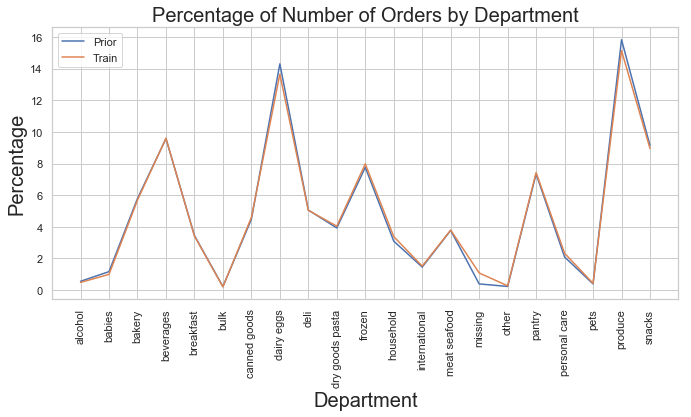

In [85]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=dept_num_ord_prior['department'], y=dept_num_ord_prior['perc'], label='Prior')
sns.lineplot(x=dept_num_ord_train['department'], y=dept_num_ord_train['perc'], label='Train')

plt.title('Percentage of Number of Orders by Department', fontsize=20)
plt.xlabel('Department', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.xticks(rotation='vertical')
plt.legend()

**A large percentage of orders are purchased from the produce, dairy eggs, beverages, frozen, and pantry departments. A small percentage of orders are purchased from the alcohol, bulk, missing, other, and pets departments.**

### What Departments are the Most Shopped at by Number of Products?

In [86]:
dept_num_prod_prior = prior_data.groupby('department')['product_name'].count().reset_index(name='count')
dept_num_prod_prior['perc'] = dept_num_prod_prior['count']*100/dept_num_prod_prior['count'].sum()
dept_num_prod_prior = dept_num_prod_prior.sort_values('perc', ascending=False)
dept_num_prod_prior.head()

,department,count,perc
19,produce,9479291,29.23
7,dairy eggs,5414016,16.69
20,snacks,2887550,8.90
3,beverages,2690129,8.29
10,frozen,2236432,6.90


In [87]:
dept_num_prod_train = train_data.groupby('department')['product_name'].count().reset_index(name='count')
dept_num_prod_train['perc'] = dept_num_prod_train['count']*100/dept_num_prod_train['count'].sum()
dept_num_prod_train = dept_num_prod_train.sort_values('perc', ascending=False)
dept_num_prod_train.head()

,department,count,perc
19,produce,409087,29.55
7,dairy eggs,217051,15.68
20,snacks,118862,8.58
3,beverages,114046,8.24
10,frozen,100426,7.25


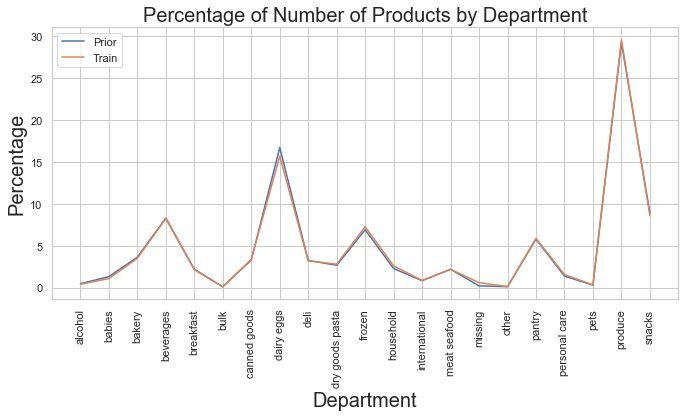

In [88]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=dept_num_prod_prior['department'], y=dept_num_prod_prior['perc'], label='Prior')
sns.lineplot(x=dept_num_prod_train['department'], y=dept_num_prod_train['perc'], label='Train')

plt.title('Percentage of Number of Products by Department', fontsize=20)
plt.xlabel('Department', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.xticks(rotation='vertical')
plt.legend()

**Most products are purchased from the produce, dairy eggs, beverages, frozen, and pantry departments. Customers buy products from the alcohol, bulk, missing, other, and pets departments the least. These are the same as the most popular and least popular departments when measuring by the number of orders.**

### What Products Do Customers Order?

In [93]:
pop_prod_prior = prior_data.groupby('product_name')['product_name'].count().reset_index(name='count')
pop_prod_prior = pop_prod_prior.sort_values('count', ascending=False)
pop_prod_prior['perc'] = pop_prod_prior['count']*100/pop_prod_prior['count'].sum()
pop_prod_prior.head(10)

,product_name,count,perc
3676,Banana,472565,1.46
3471,Bag of Organic Bananas,379450,1.17
31920,Organic Strawberries,264683,0.82
28840,Organic Baby Spinach,241921,0.75
30297,Organic Hass Avocado,213584,0.66
28804,Organic Avocado,176815,0.55
22413,Large Lemon,152657,0.47
42904,Strawberries,142951,0.44
23420,Limes,140627,0.43
32478,Organic Whole Milk,137905,0.43


In [94]:
pop_prod_train = train_data.groupby('product_name')['product_name'].count().reset_index(name='count')
pop_prod_train = pop_prod_train.sort_values('count', ascending=False)
pop_prod_train['perc'] = pop_prod_train['count']*100/pop_prod_train['count'].sum()
pop_prod_train.head(10)

,product_name,count,perc
2814,Banana,18726,1.35
2641,Bag of Organic Bananas,15480,1.12
25128,Organic Strawberries,10894,0.79
22496,Organic Baby Spinach,9784,0.71
17475,Large Lemon,8135,0.59
22465,Organic Avocado,7409,0.54
23736,Organic Hass Avocado,7293,0.53
33836,Strawberries,6494,0.47
18278,Limes,6033,0.44
24656,Organic Raspberries,5546,0.40


(0.2, 1.5)

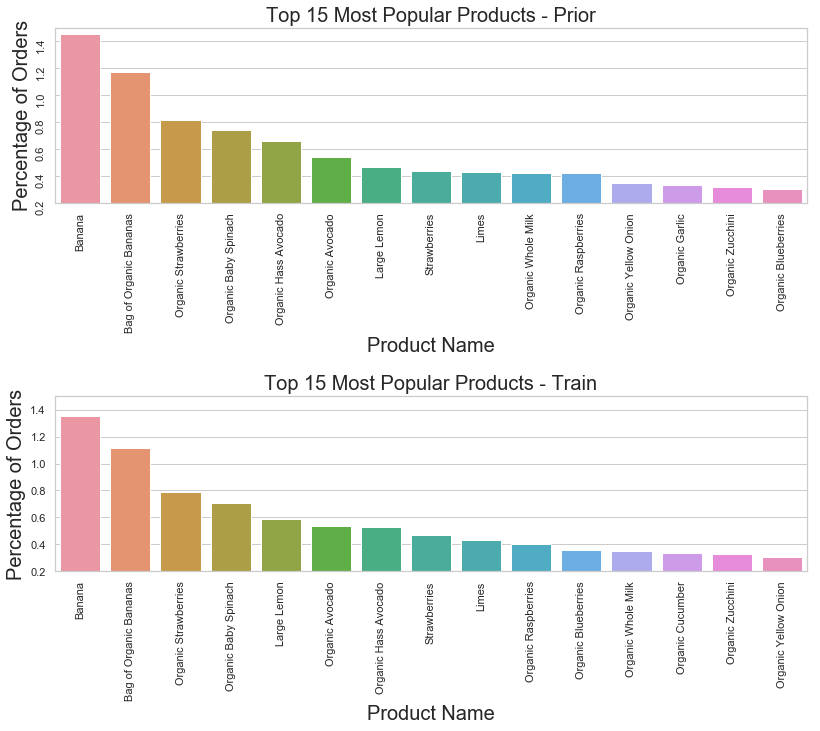

In [95]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(12, 10))
plt.xticks(rotation='vertical')
plt.subplots_adjust(hspace=1.1)

ax1 = sns.barplot(x=pop_prod_prior['product_name'][:15], y=pop_prod_prior['perc'][:15], ax=ax[0])
ax1.set_title('Top 15 Most Popular Products - Prior', fontsize=20)
ax1.set_xlabel('Product Name', fontsize=20)
ax1.set_ylabel('Percentage of Orders', fontsize=20)
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0.2, 1.5)

ax2 = sns.barplot(x=pop_prod_train['product_name'][:15], y=pop_prod_train['perc'][:15], ax=ax[1])
ax2.set_title('Top 15 Most Popular Products - Train', fontsize=20)
ax2.set_xlabel('Product Name', fontsize=20)
ax2.set_ylabel('Percentage of Orders', fontsize=20)
ax2.set_ylim(0.2, 1.5)

In [92]:
print('There are {} unique products in the prior dataset.'.format(len(prior_data['product_name'].unique())))
print('There are {} unique products in the train dataset.'.format(len(train_data['product_name'].unique())))

There are 49677 unique products in the prior dataset.
There are 39123 unique products in the train dataset.


**The majority of the top 15 most sold products are fruits and vegetables, which is verified by the most popular aisles, fresh fruits and fresh vegetables, and the department, produce. Something to note is that of the 15 most frequently bought products, 11 are organic! Let's dive deeper into organic products later.**

### How Often Do Customers Reorder Items?

In [96]:
reord_prior = prior_data.groupby('reordered')['reordered'].count().reset_index(name='count')
reord_prior['perc'] = reord_prior['count']/reord_prior['count'].sum()
reord_prior

,reordered,count,perc
0,0,13307953,0.41
1,1,19126536,0.59


In [97]:
reord_train = train_data.groupby('reordered')['reordered'].count().reset_index(name='count')
reord_train['perc'] = reord_train['count']/reord_train['count'].sum()
reord_train

,reordered,count,perc
0,0,555793,0.40
1,1,828824,0.60


**Of the prior dataset, 59% of the products are reordered, while 41% are not. For the train dataset, 60% of the products are reordered, while 40% are not.**

### How Many Days Has It Been Before a Reorder?

In [98]:
days_prior_order = orders.groupby('days_since_prior_order')['order_id'].nunique().reset_index(name='count')
days_prior_order.head()

,days_since_prior_order,count
0,0.00,67755
1,1.00,145247
2,2.00,193206
3,3.00,217005
4,4.00,221696


Text(0,0.5,'Number of Orders')

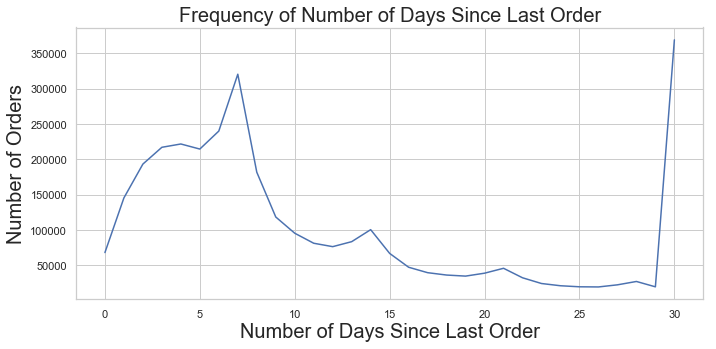

In [99]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=days_prior_order['days_since_prior_order'], y=days_prior_order['count'])

plt.title('Frequency of Number of Days Since Last Order', fontsize=20)
plt.xlabel('Number of Days Since Last Order', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)

**Users tend to order in intervals of some multiple of 7 (7, 14, 21, or 28 days) or monthly (30 days).**

### What Relationship Does the Number of Days Since the Last Order Have With The Probability of Reordering?

In [100]:
days_prior_reord = prior_data.groupby('days_since_prior_order')['reordered'].mean().reset_index(name='prob_prior')
days_prior_reord.head()

,days_since_prior_order,prob_prior
0,0.00,0.74
1,1.00,0.62
2,2.00,0.65
3,3.00,0.67
4,4.00,0.68


In [101]:
days_train_reord = train_data.groupby('days_since_prior_order')['reordered'].mean().reset_index(name='prob_train')
days_train_reord.head()

,days_since_prior_order,prob_train
0,0.00,0.82
1,1.00,0.62
2,2.00,0.62
3,3.00,0.65
4,4.00,0.68


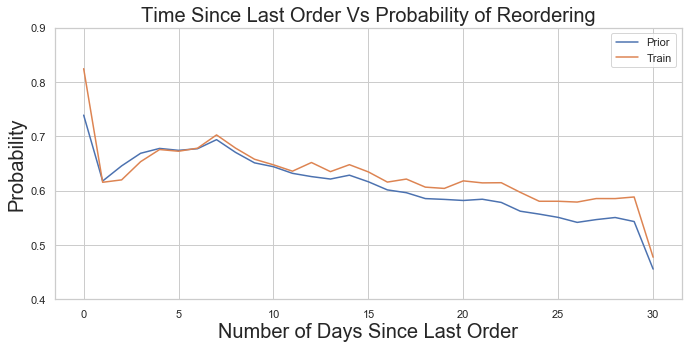

In [103]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=days_prior_reord['days_since_prior_order'], y=days_prior_reord['prob_prior'], label='Prior')
sns.lineplot(x=days_train_reord['days_since_prior_order'], y=days_train_reord['prob_train'], label='Train')

plt.title('Time Since Last Order Vs Probability of Reordering', fontsize=20)
plt.xlabel('Number of Days Since Last Order', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0.4, 0.9)
plt.legend()

**The number of days since the last order is capped from 0-30 days. The overall trend seems to be as more days pass by since the last order, the less likely customers will reorder. This is intuitive because if a customer doesn't like a product, interest for the product and the chances of reordering will fall as time pass. The longer since the last order, the more likely the customer won't reorder.**

### What Relationship Does the Order of Items Placed in Cart Have With The Probability of Reordering?

In [107]:
cart_prior_reord = prior_data.groupby('add_to_cart_order')['reordered'].mean().reset_index(name='prob_prior')
cart_prior_reord.head()

,add_to_cart_order,prob_prior
0,1,0.68
1,2,0.68
2,3,0.66
3,4,0.64
4,5,0.62


In [108]:
cart_train_reord = train_data.groupby('add_to_cart_order')['reordered'].mean().reset_index(name='prob_train')
cart_train_reord.head()

,add_to_cart_order,prob_train
0,1,0.72
1,2,0.70
2,3,0.67
3,4,0.65
4,5,0.62


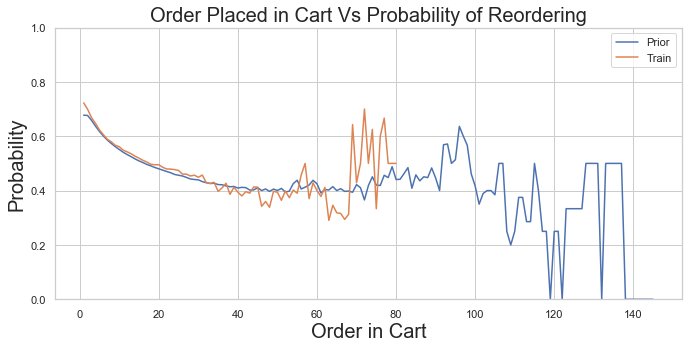

In [109]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=cart_prior_reord['add_to_cart_order'], y=cart_prior_reord['prob_prior'], label='Prior')
sns.lineplot(x=cart_train_reord['add_to_cart_order'], y=cart_train_reord['prob_train'], label='Train')

plt.title('Order Placed in Cart Vs Probability of Reordering', fontsize=20)
plt.xlabel('Order in Cart', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0, 1)
plt.legend()

**The probability of an item being reordered decreases exponentially as its order added to the cart increases in a cart of size 1 to 50 items. After the 50 item mark, the trend is less coherent with sharp dips and rises. We observe a smoother trend for 1-50 items maybe because most orders don't have more than 50 items. Therefore, the curve of the average probability is smoothed out by the abundant data, whereas there is less data (maybe one or two orders with 9x items) as the order of items placed in cart increases. For example, if a product that was placed 90th in the cart was reordered, this information would greatly affect the average probability of 90th items being reordered.**

### What are Reorder Behaviors by Day of Week?

In [113]:
reord_dow_prior = prior_data.groupby('order_dow')['reordered'].mean().reset_index(name='prob')
reord_dow_prior

,order_dow,prob
0,Sunday,0.59
1,Monday,0.60
2,Tuesday,0.59
3,Wednesday,0.59
4,Thursday,0.59
5,Friday,0.60
6,Saturday,0.57


In [114]:
reord_dow_train = train_data.groupby('order_dow')['reordered'].mean().reset_index(name='prob')
reord_dow_train

,order_dow,prob
0,Sunday,0.61
1,Monday,0.60
2,Tuesday,0.59
3,Wednesday,0.59
4,Thursday,0.59
5,Friday,0.61
6,Saturday,0.59


(0.55, 0.61)

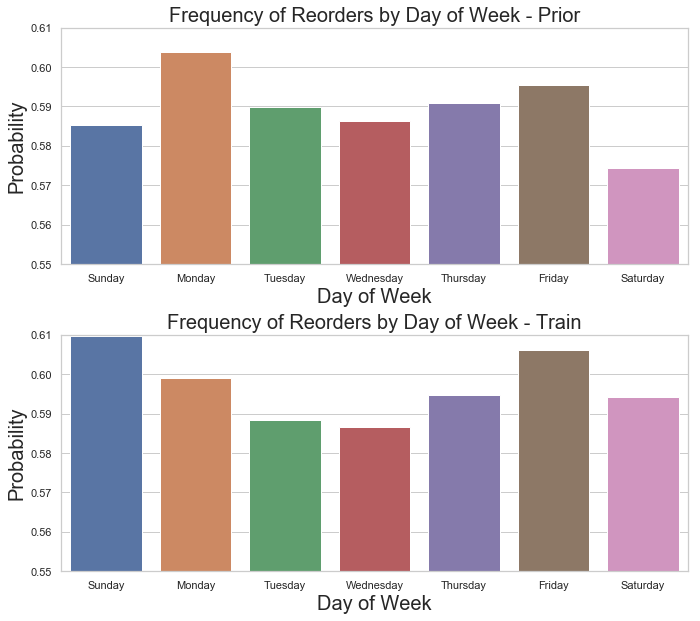

In [115]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

ax1 = sns.barplot(reord_dow_prior['order_dow'], y=reord_dow_prior['prob'], ax=ax[0])
ax1.set_title('Frequency of Reorders by Day of Week - Prior', fontsize=20)
ax1.set_xlabel('Day of Week', fontsize=20)
ax1.set_ylabel('Probability', fontsize=20)
ax1.set_ylim(0.55, 0.61)

ax2 = sns.barplot(reord_dow_train['order_dow'], y=reord_dow_train['prob'], ax=ax[1])
ax2.set_title('Frequency of Reorders by Day of Week - Train', fontsize=20)
ax2.set_xlabel('Day of Week', fontsize=20)
ax2.set_ylabel('Probability', fontsize=20)
ax2.set_ylim(0.55, 0.61)

**Customers in the prior dataset reorder slightly more on Mondays and Fridays, while customers in the train dataset reorder more on Sundays and Fridays.**

### What are Reorder Behaviors by Hour of Day?

In [116]:
reord_hod_prior = prior_data.groupby('order_hour_of_day')['reordered'].mean().reset_index(name='prob')
reord_hod_prior

,order_hour_of_day,prob
0,0,0.57
1,1,0.56
2,2,0.55
3,3,0.56
4,4,0.57
5,5,0.61
6,6,0.64
7,7,0.64
8,8,0.63
9,9,0.62


In [117]:
reord_hod_train = train_data.groupby('order_hour_of_day')['reordered'].mean().reset_index(name='prob')
reord_hod_train

,order_hour_of_day,prob
0,0,0.57
1,1,0.58
2,2,0.58
3,3,0.58
4,4,0.60
5,5,0.62
6,6,0.65
7,7,0.65
8,8,0.64
9,9,0.62


(0.5, 0.65)

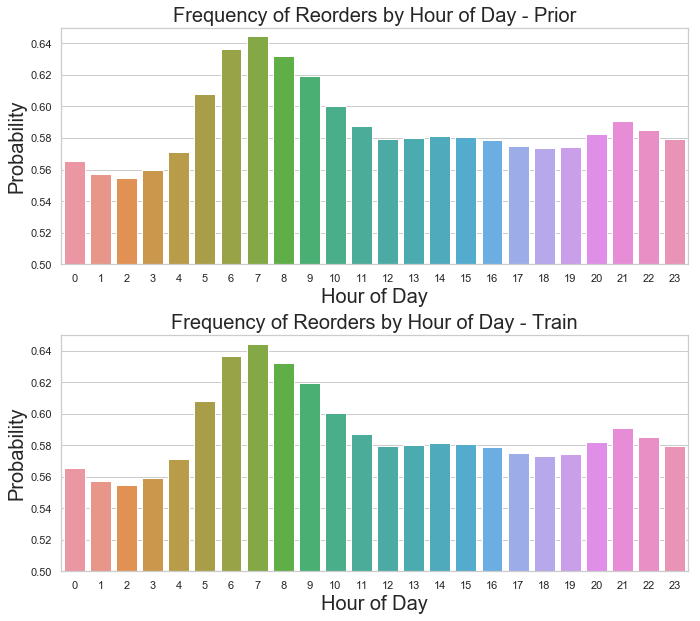

In [118]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

ax1 = sns.barplot(reord_hod_prior['order_hour_of_day'], y=reord_hod_prior['prob'], ax=ax[0])
ax1.set_title('Frequency of Reorders by Hour of Day - Prior', fontsize=20)
ax1.set_xlabel('Hour of Day', fontsize=20)
ax1.set_ylabel('Probability', fontsize=20)
ax1.set_ylim(0.5, 0.65)

ax2 = sns.barplot(reord_hod_prior['order_hour_of_day'], y=reord_hod_prior['prob'], ax=ax[1])
ax2.set_title('Frequency of Reorders by Hour of Day - Train', fontsize=20)
ax2.set_xlabel('Hour of Day', fontsize=20)
ax2.set_ylabel('Probability', fontsize=20)
ax2.set_ylim(0.5, 0.65)

**Customers reorder more often during 6-9 AM than the other hours of the day. There is a smaller mode between 8-11 PM, most likely for a regular go-to late night snack or meal.**

### What are Reorder Behaviors by Day of Week Vs Hour of Day?

In [119]:
dow_vs_hod_prior = prior_data.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean().reset_index(name='prob')
dow_vs_hod_prior = dow_vs_hod_prior.pivot('order_dow', 'order_hour_of_day', 'prob')
dow_vs_hod_prior.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
Sunday,0.58,0.55,0.55,0.57,0.55,0.59,0.62,0.64,0.63,0.61,0.59,0.58,0.57,0.58,0.58,0.58,0.58,0.57,0.57,0.58,0.60,0.61,0.60,0.60
Monday,0.59,0.59,0.56,0.57,0.60,0.63,0.66,0.67,0.66,0.65,0.63,0.61,0.59,0.59,0.59,0.58,0.58,0.58,0.57,0.57,0.58,0.58,0.58,0.58
Tuesday,0.56,0.56,0.56,0.58,0.56,0.61,0.64,0.64,0.63,0.62,0.60,0.59,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.57,0.57,0.58,0.57,0.57
Wednesday,0.55,0.54,0.54,0.55,0.55,0.60,0.63,0.64,0.62,0.61,0.59,0.58,0.58,0.58,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57
Thursday,0.56,0.54,0.55,0.56,0.58,0.60,0.64,0.64,0.62,0.61,0.59,0.59,0.58,0.58,0.58,0.59,0.58,0.59,0.58,0.58,0.59,0.60,0.58,0.57


In [120]:
dow_vs_hod_train = train_data.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean().reset_index(name='prob')
dow_vs_hod_train = dow_vs_hod_train.pivot('order_dow', 'order_hour_of_day', 'prob')
dow_vs_hod_train.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
Sunday,0.58,0.59,0.59,0.55,0.60,0.61,0.65,0.68,0.67,0.64,0.62,0.60,0.59,0.59,0.60,0.59,0.60,0.61,0.59,0.61,0.62,0.64,0.62,0.61
Monday,0.62,0.55,0.51,0.66,0.63,0.60,0.66,0.66,0.65,0.64,0.62,0.60,0.59,0.60,0.60,0.57,0.58,0.57,0.57,0.60,0.55,0.60,0.57,0.59
Tuesday,0.59,0.62,0.60,0.57,0.64,0.63,0.63,0.64,0.62,0.60,0.59,0.59,0.59,0.58,0.58,0.59,0.57,0.58,0.57,0.59,0.59,0.58,0.59,0.57
Wednesday,0.61,0.51,0.62,0.55,0.47,0.64,0.67,0.62,0.63,0.62,0.59,0.60,0.58,0.58,0.58,0.57,0.57,0.57,0.59,0.56,0.59,0.58,0.57,0.57
Thursday,0.53,0.58,0.54,0.59,0.62,0.67,0.68,0.64,0.63,0.59,0.59,0.58,0.58,0.59,0.59,0.59,0.59,0.61,0.59,0.59,0.59,0.61,0.59,0.59


Text(34.0531,0.5,'Day of Week')

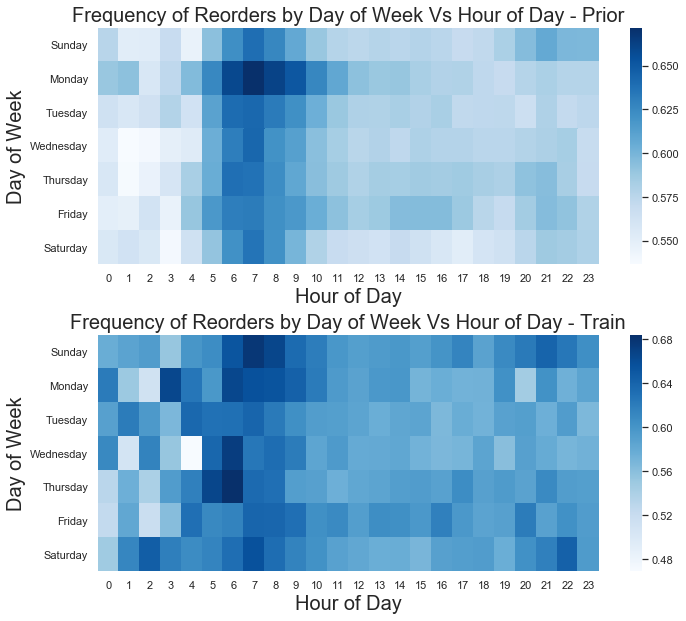

In [121]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

ax1 = sns.heatmap(dow_vs_hod_prior, cmap='Blues', ax=ax[0])
ax1.set_title('Frequency of Reorders by Day of Week Vs Hour of Day - Prior', fontsize=20)
ax1.set_xlabel('Hour of Day', fontsize=20)
ax1.set_ylabel('Day of Week', fontsize=20)

ax2 = sns.heatmap(dow_vs_hod_train, cmap='Blues', ax=ax[1])
ax2.set_title('Frequency of Reorders by Day of Week Vs Hour of Day - Train', fontsize=20)
ax2.set_xlabel('Hour of Day', fontsize=20)
ax2.set_ylabel('Day of Week', fontsize=20)

**Overall, customers tend to reorder during the early mornings (5-9 AM) rather than the later half of the day for all days of the week. There is some high frequency of reorders in the train dataset scattered in the wee hours up to 10 AM.**

### What Aisles Do Customers Reorder From?

In [122]:
reord_aisle_prior = prior_data.groupby('aisle')['reordered'].sum().reset_index()
reord_aisle_prior = reord_aisle_prior.merge(aisle_num_prod_prior[['aisle', 'count']], on='aisle')
reord_aisle_prior['prob'] = reord_aisle_prior['reordered']/reord_aisle_prior['count']
reord_aisle_prior = reord_aisle_prior.sort_values('prob', ascending=False)
reord_aisle_prior.head(10)

,aisle,reordered,count,prob
83,milk,696264,891015,0.78
131,water seltzer sparkling water,613977,841533,0.73
50,fresh fruits,2615469,3642188,0.72
41,eggs,318920,452134,0.71
119,soy lactosefree,442023,638253,0.69
96,packaged produce,190662,276028,0.69
133,yogurt,997018,1452343,0.69
33,cream,217846,318002,0.69
11,bread,391937,584834,0.67
110,refrigerated,381983,575881,0.66


In [123]:
reord_aisle_train = train_data.groupby('aisle')['reordered'].sum().reset_index()
reord_aisle_train = reord_aisle_train.merge(aisle_num_prod_train[['aisle', 'count']], on='aisle')
reord_aisle_train['prob'] = reord_aisle_train['reordered']/reord_aisle_train['count']
reord_aisle_train = reord_aisle_train.sort_values('prob', ascending=False)
reord_aisle_train.head(10)

,aisle,reordered,count,prob
85,missing,3148,69145,0.05
96,packaged produce,9657,276028,0.03
131,water seltzer sparkling water,27011,841533,0.03
41,eggs,14488,452134,0.03
50,fresh fruits,110782,3642188,0.03
95,packaged poultry,3553,118437,0.03
23,cat food care,1882,63421,0.03
43,energy sports drinks,3066,103615,0.03
117,soft drinks,10575,357537,0.03
98,packaged vegetables fruits,51523,1765313,0.03


(0.025, 0.05)

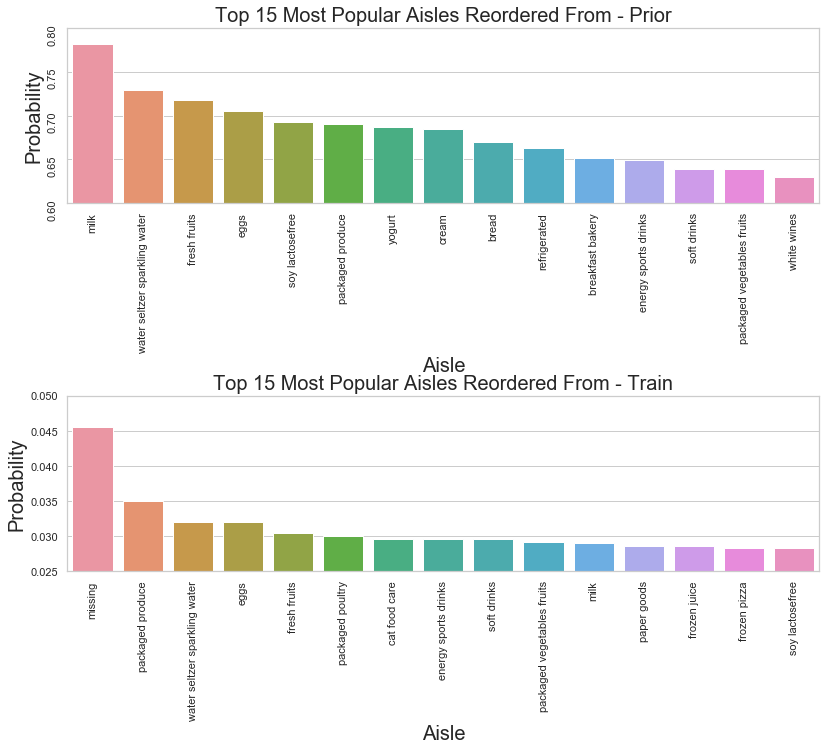

In [124]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(12, 10))
plt.xticks(rotation='vertical')
plt.subplots_adjust(hspace=1.1)

ax1 = sns.barplot(x=reord_aisle_prior['aisle'][:15], y=reord_aisle_prior['prob'][:15], ax=ax[0])
ax1.set_title('Top 15 Most Popular Aisles Reordered From - Prior', fontsize=20)
ax1.set_xlabel('Aisle', fontsize=20)
ax1.set_ylabel('Probability', fontsize=20)
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0.6, 0.8)

ax2 = sns.barplot(x=reord_aisle_train['aisle'][:15], y=reord_aisle_train['prob'][:15], ax=ax[1])
ax2.set_title('Top 15 Most Popular Aisles Reordered From - Train', fontsize=20)
ax2.set_xlabel('Aisle', fontsize=20)
ax2.set_ylabel('Probability', fontsize=20)
ax2.set_ylim(0.025, 0.05)

In [125]:
train_data[train_data['aisle']=='missing']

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle,department
701,2364180,104,train,6,Thursday,10,10.00,10,0,Organic Chopped BBQ Ranch Salad Kit,missing,missing
766,72069,110,train,21,Monday,10,6.00,17,1,Organic Riced Cauliflower,missing,missing
1000,1993128,143,train,15,Saturday,11,8.00,13,0,Dark Chocolate Sea Salt Granola Bites,missing,missing
1846,1162736,261,train,9,Wednesday,17,4.00,28,0,Layered Salted Caramel & Dark Chocolate Chewy ...,missing,missing
2037,208213,296,train,7,Wednesday,12,4.00,13,0,White Apple Cauliflower & Leek Organic Baby Food,missing,missing
2930,1848722,446,train,9,Saturday,16,30.00,16,0,Honey Almond Butter W/ Pretzels,missing,missing
3034,3293782,466,train,32,Friday,16,14.00,8,1,Organic Nondairy Strawberry Cashew Yogurt,missing,missing
3035,3293782,466,train,32,Friday,16,14.00,9,1,Organic Cashew Nondairy Blueberry Yogurt,missing,missing
3174,1039817,480,train,13,Friday,13,4.00,10,0,Light Creamy Swiss Flavor Spreadable Cheese We...,missing,missing
3554,2569637,526,train,5,Monday,13,14.00,19,1,Spongebob Squarepants Go Gurt Strawberry & Cot...,missing,missing


**In the prior set, customers reorder most from the dairy and eggs, beverages, and produce aisles. In the train set, although at a small probability of 0.045, customers reorder most from the missing aisle. The next 14 most popular aisles reordered from are mainly produce, beverages, and dairy and eggs. Unlike in the prior set where all aisles contain items that are edible, two of the most popular aisles reordered from in the train set are cat food and paper goods.**

**We can see that there are produce, dairy, frozen items, etc. in the missing aisle and department and that these goods were (re)ordered meaning that these aren't missing products. The missing aisle might be named so because the information for the aisle category is missing, and the products that should be allocated to other aisle categories are not.**

### What Departments Do Customers Reorder From?

In [126]:
reord_dept_prior = prior_data.groupby('department')['reordered'].sum().reset_index()
reord_dept_prior = reord_dept_prior.merge(dept_num_prod_prior[['department', 'count']], on='department')
reord_dept_prior['prob'] = reord_dept_prior['reordered']/reord_dept_prior['count']
reord_dept_prior = reord_dept_prior.sort_values('prob', ascending=False)
reord_dept_prior.head(10)

,department,reordered,count,prob
7,dairy eggs,3627221,5414016,0.67
3,beverages,1757892,2690129,0.65
19,produce,6160710,9479291,0.65
2,bakery,739188,1176787,0.63
8,deli,638864,1051249,0.61
18,pets,58760,97724,0.60
1,babies,245369,423802,0.58
5,bulk,19950,34573,0.58
20,snacks,1657973,2887550,0.57
0,alcohol,87595,153696,0.57


In [127]:
reord_dept_train = train_data.groupby('department')['reordered'].sum().reset_index()
reord_dept_train = reord_dept_train.merge(dept_num_prod_train[['department', 'count']], on='department')
reord_dept_train['prob'] = reord_dept_train['reordered']/reord_dept_train['count']
reord_dept_train = reord_dept_train.sort_values('prob', ascending=False)
reord_dept_train.head(10)

,department,reordered,count,prob
7,dairy eggs,146502,217051,0.67
19,produce,271886,409087,0.66
3,beverages,75060,114046,0.66
2,bakery,30692,48394,0.63
18,pets,2834,4497,0.63
8,deli,27367,44291,0.62
0,alcohol,3397,5598,0.61
13,meat seafood,17907,30307,0.59
20,snacks,69102,118862,0.58
5,bulk,786,1359,0.58


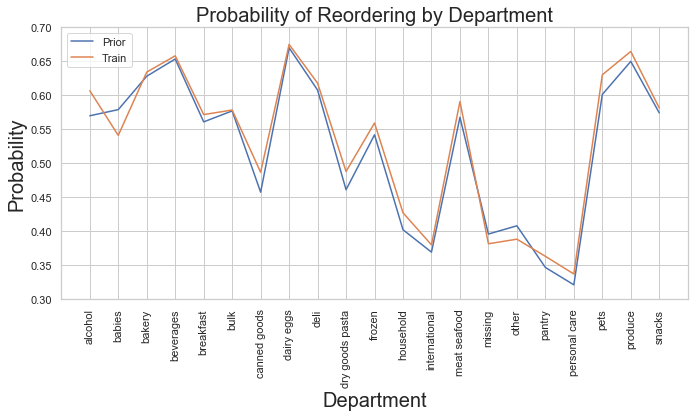

In [128]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=reord_dept_prior['department'], y=reord_dept_prior['prob'], label='Prior')
sns.lineplot(x=reord_dept_train['department'], y=reord_dept_train['prob'], label='Train')

plt.title('Probability of Reordering by Department', fontsize=20)
plt.xlabel('Department', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0.3, 0.7)
plt.xticks(rotation='vertical')
plt.legend()

**Customers mostly reorder goods from the dairy eggs, produce, beverages, bakery, pets, deli, and snacks departments. Personal care, pantry, and international are some of the least reordered departments.**

### Which Items are Most Frequently Reordered?

In [140]:
prod_reord_prior = train_data.groupby(['product_name'])['reordered'].sum().reset_index()
prod_reord_prior = prod_reord_prior.merge(pop_prod_prior[['product_name', 'count']], on='product_name')
prod_reord_prior['prob'] = prod_reord_prior['reordered']/prod_reord_prior['count']
prod_reord_prior = prod_reord_prior[prod_reord_prior['count']>100]
prod_reord_prior = prod_reord_prior.sort_values('prob', ascending=False)
prod_reord_prior.head(10)

,product_name,reordered,count,prob
27096,Peanut Chocolate Candies,24,173,0.14
5018,Canned Diet,15,128,0.12
3846,Blueberry Cashew Bar,14,128,0.11
24483,Organic Pink Lady (Cripps) Apple,31,296,0.10
13280,Ginger Lemon Kombucha,16,157,0.10
25381,Organic Uncured Beef Hot Dog,51,518,0.10
2766,Balanced Breaks Natural Sharp White Cheddar Ch...,11,113,0.10
5042,Cantaloupes,12,124,0.10
14750,Ground Chuck,10,105,0.10
12817,Fuji Apple,17,179,0.09


In [136]:
prod_reord_train = train_data.groupby(['product_name'])['reordered'].sum().reset_index()
prod_reord_train = prod_reord_train.merge(pop_prod_train[['product_name', 'count']], on='product_name')
prod_reord_train['prob'] = prod_reord_train['reordered']/prod_reord_train['count']
prod_reord_train = prod_reord_train[prod_reord_train['count']>100]
prod_reord_train = prod_reord_train.sort_values('prob', ascending=False)
prod_reord_train.head(10)

,product_name,reordered,count,prob
24054,Organic Low Fat Milk,336,368,0.91
2814,Banana,16557,18726,0.88
27414,Petit Suisse Fruit,106,120,0.88
24075,Organic Lowfat 1% Milk,426,483,0.88
23953,Organic Lactose Free 1% Lowfat Milk,237,269,0.88
43,1% Lowfat Milk,405,461,0.88
24757,Organic Reduced Fat Milk,1056,1206,0.88
23790,Organic Homogenized Whole Milk,109,125,0.87
23352,Organic Fat Free Milk,705,811,0.87
19964,"Milk, Organic, Vitamin D",497,572,0.87


(0.85, 0.92)

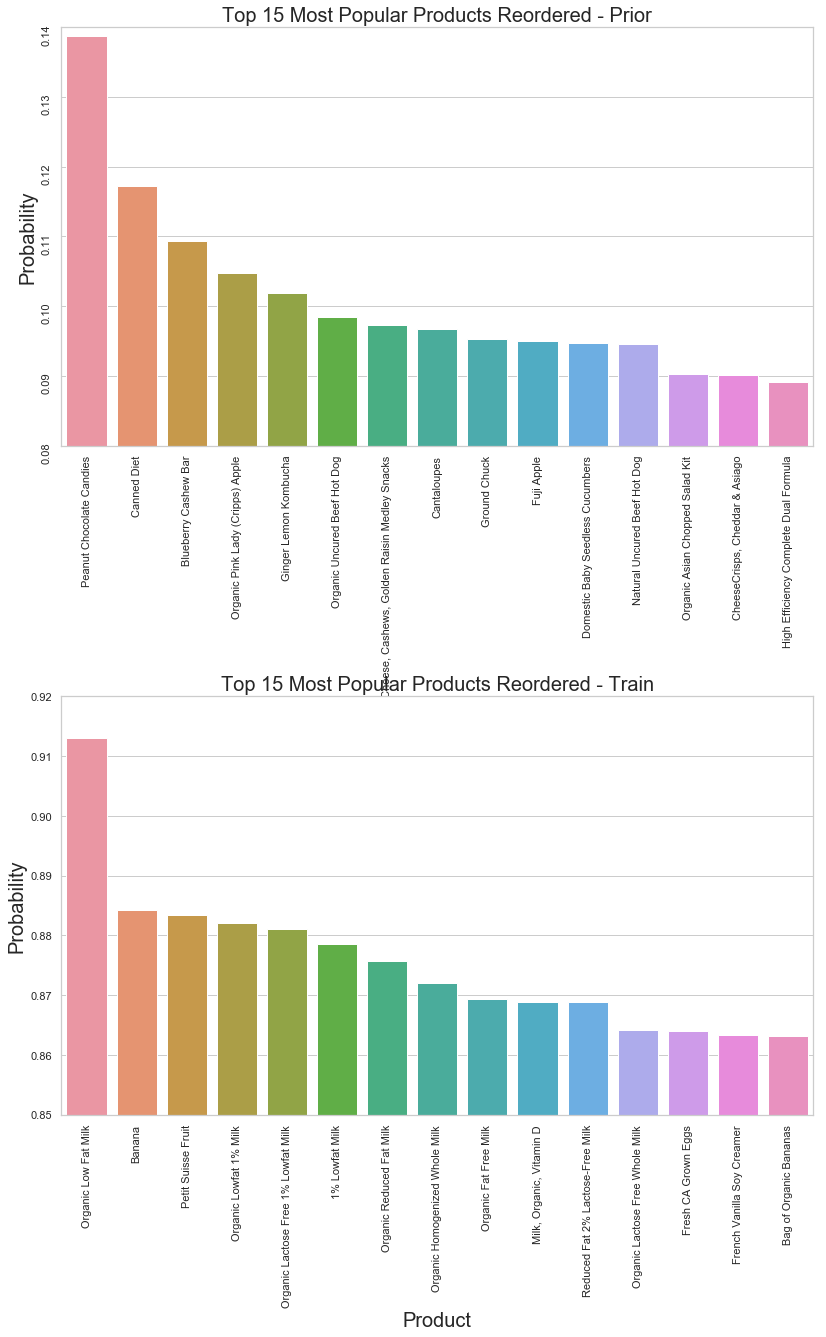

In [149]:
sns.set(style='whitegrid')
f, ax = plt.subplots(2, 1, figsize=(12, 20))
plt.xticks(rotation='vertical')
plt.subplots_adjust(hspace=0.6)

ax1 = sns.barplot(x=prod_reord_prior['product_name'][:15], y=prod_reord_prior['prob'][:15], ax=ax[0])
ax1.set_title('Top 15 Most Popular Products Reordered - Prior', fontsize=20)
ax1.set_xlabel('Product', fontsize=20)
ax1.set_ylabel('Probability', fontsize=20)
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0.08, 0.14)

ax2 = sns.barplot(x=prod_reord_train['product_name'][:15], y=prod_reord_train['prob'][:15], ax=ax[1])
ax2.set_title('Top 15 Most Popular Products Reordered - Train', fontsize=20)
ax2.set_xlabel('Product', fontsize=20)
ax2.set_ylabel('Probability', fontsize=20)
ax2.set_ylim(0.85, 0.92)

**https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2**

**Only items that were ordered more than 100 times were included because some items that are purchased very few times (ie, once) and reordered have very high probabilities of being reordered, which is not useful in helping us understand which items are bought and reordered frequently. For the prior set, the items most reordered are not in the train set, consisting of a variety of snacks, fruits, beverages, etc. The probabilities are much lower because that dataset includes more transactions than the train set. On the other hand, the items most frequently reordered in the train set are mostly dairy with some fruits and eggs.**

**By just looking at the names, the 15 most reordered items in the prior set are pretty specific maybe because they do not have close substitutes or have strong brand loyalty; hence, the higher inclination for customers to repurchase those items. As for the train set, although most of the products are milk, there are many different variations: organic vs not organic, whole vs 2% vs 1%, etc. that have a similar effect as that of products with a few close substitutes.**

### How Often Do Customers Order Organic Items?

In [150]:
prior_data['organic'] = np.where(prior_data['product_name'].str.contains('Organic'), 1, 0)
train_data['organic'] = np.where(train_data['product_name'].str.contains('Organic'), 1, 0)

In [153]:
organic_cts_prior = prior_data.groupby('organic')['organic'].count().reset_index(name='count')
organic_cts_prior['perc'] = organic_cts_prior['count']/organic_cts_prior['count'].sum()
organic_cts_prior

,organic,count,perc
0,0,22184097,0.68
1,1,10250392,0.32


In [154]:
organic_cts_train = train_data.groupby('organic')['organic'].count().reset_index(name='count')
organic_cts_train['perc'] = organic_cts_train['count']/organic_cts_train['count'].sum()
organic_cts_train

,organic,count,perc
0,0,979021,0.71
1,1,405596,0.29


**About 30% of the products are organic while 70% are not. This is reasonable because besides departments like produce and dairy and eggs, most departments like deli, bulk, and frozen don't provide organic options.**

### How Often Do Customers Reorder Organic Items?

In [152]:
organic_reord = prior_data.groupby('organic')['reordered'].mean().reset_index(name='prob')
organic_reord

,organic,prob
0,0,0.57
1,1,0.63


**Although only a third of the products are organic, there is almost a 2/3 chance that an organic product will be reordered.**

## Most important Aisles in each Department (by number of Products)

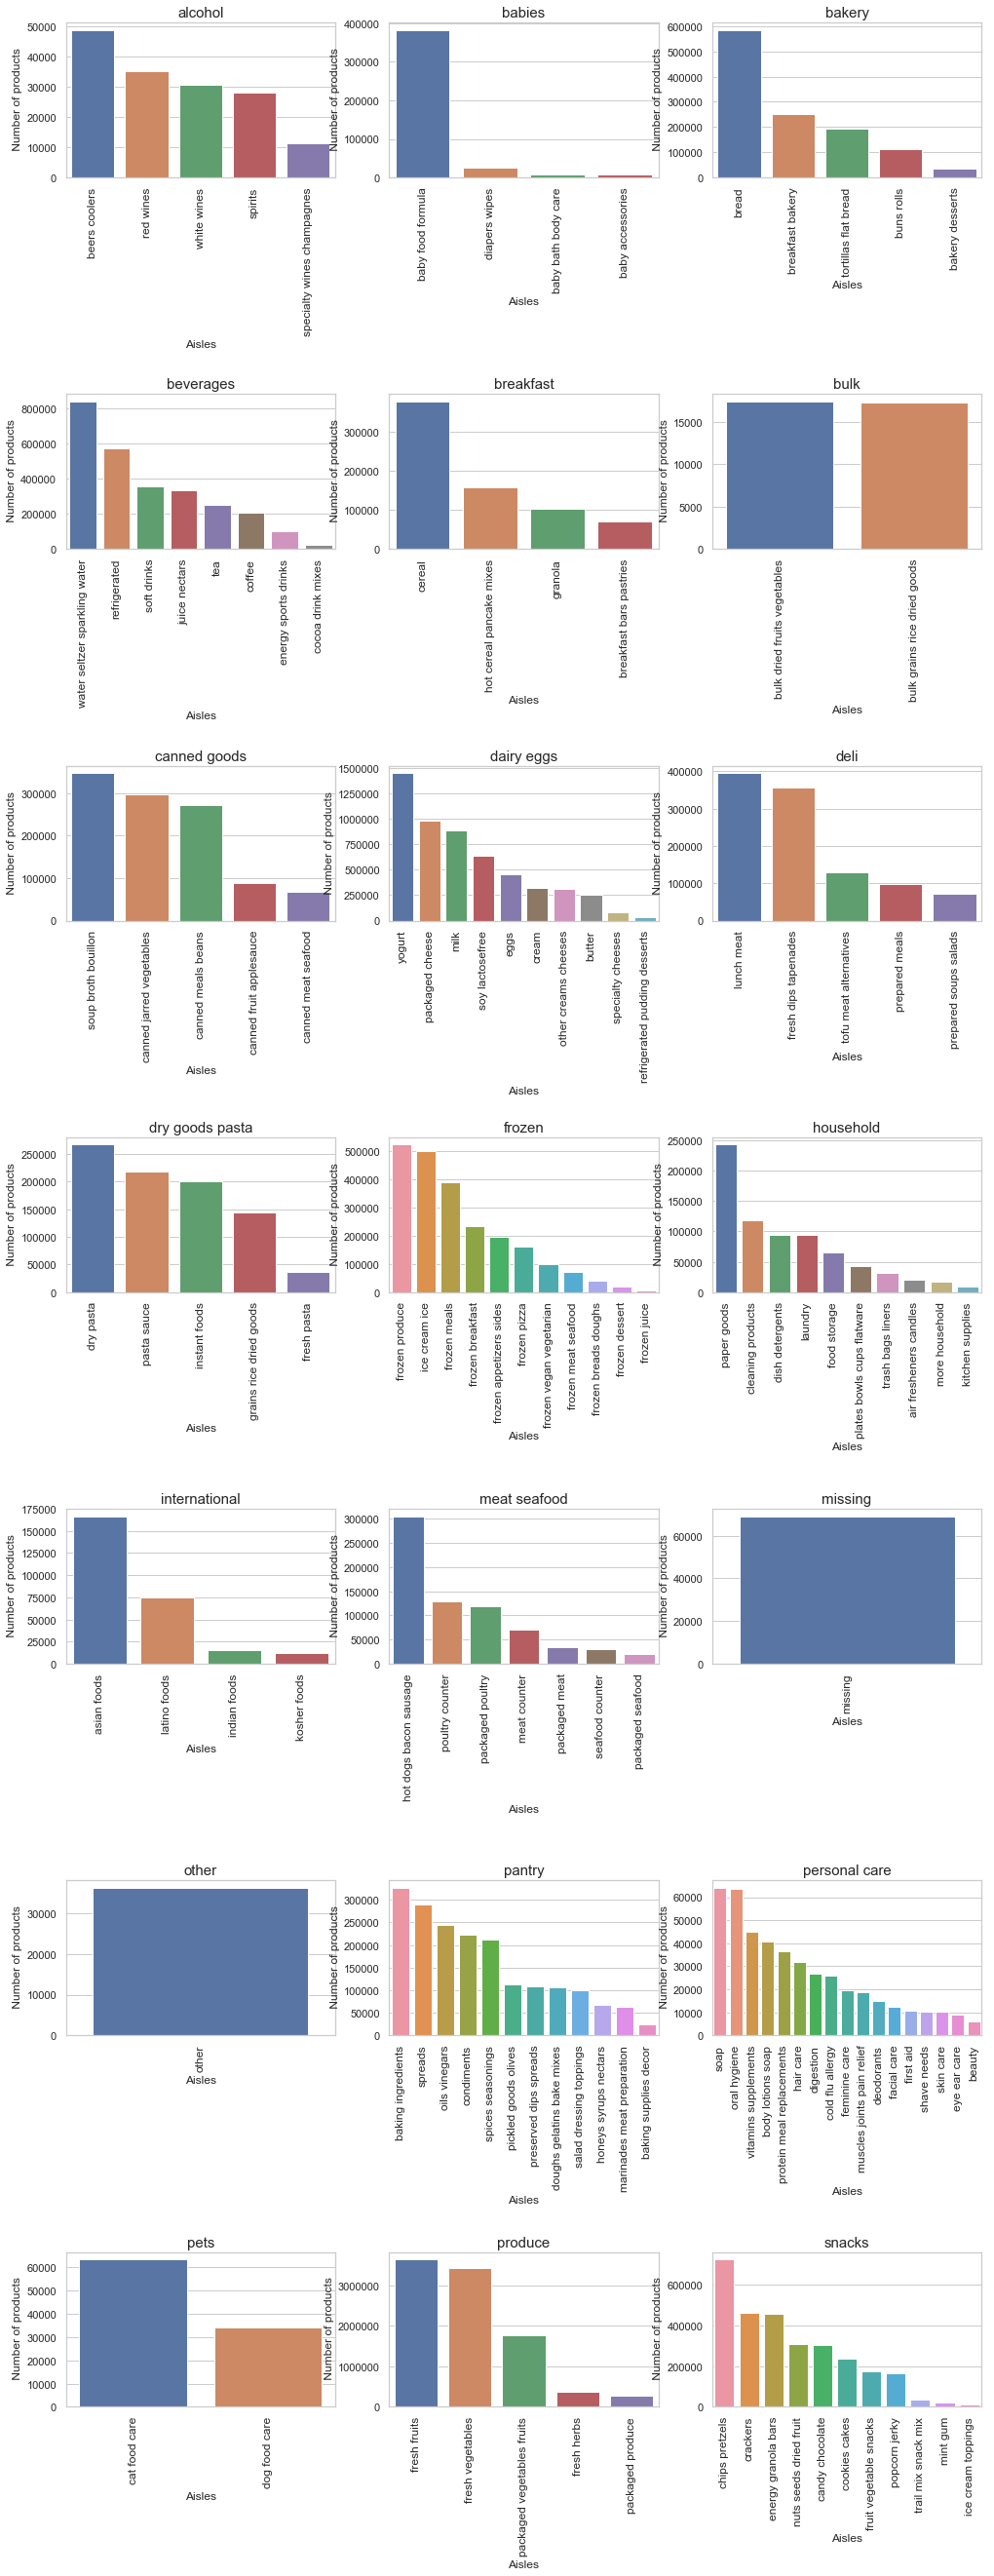

In [129]:
grouped = prior_data.groupby(["department", "aisle"])["product_name"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7, 3, figsize=(15,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

## Best Selling Aisles in each Department (number of Orders)

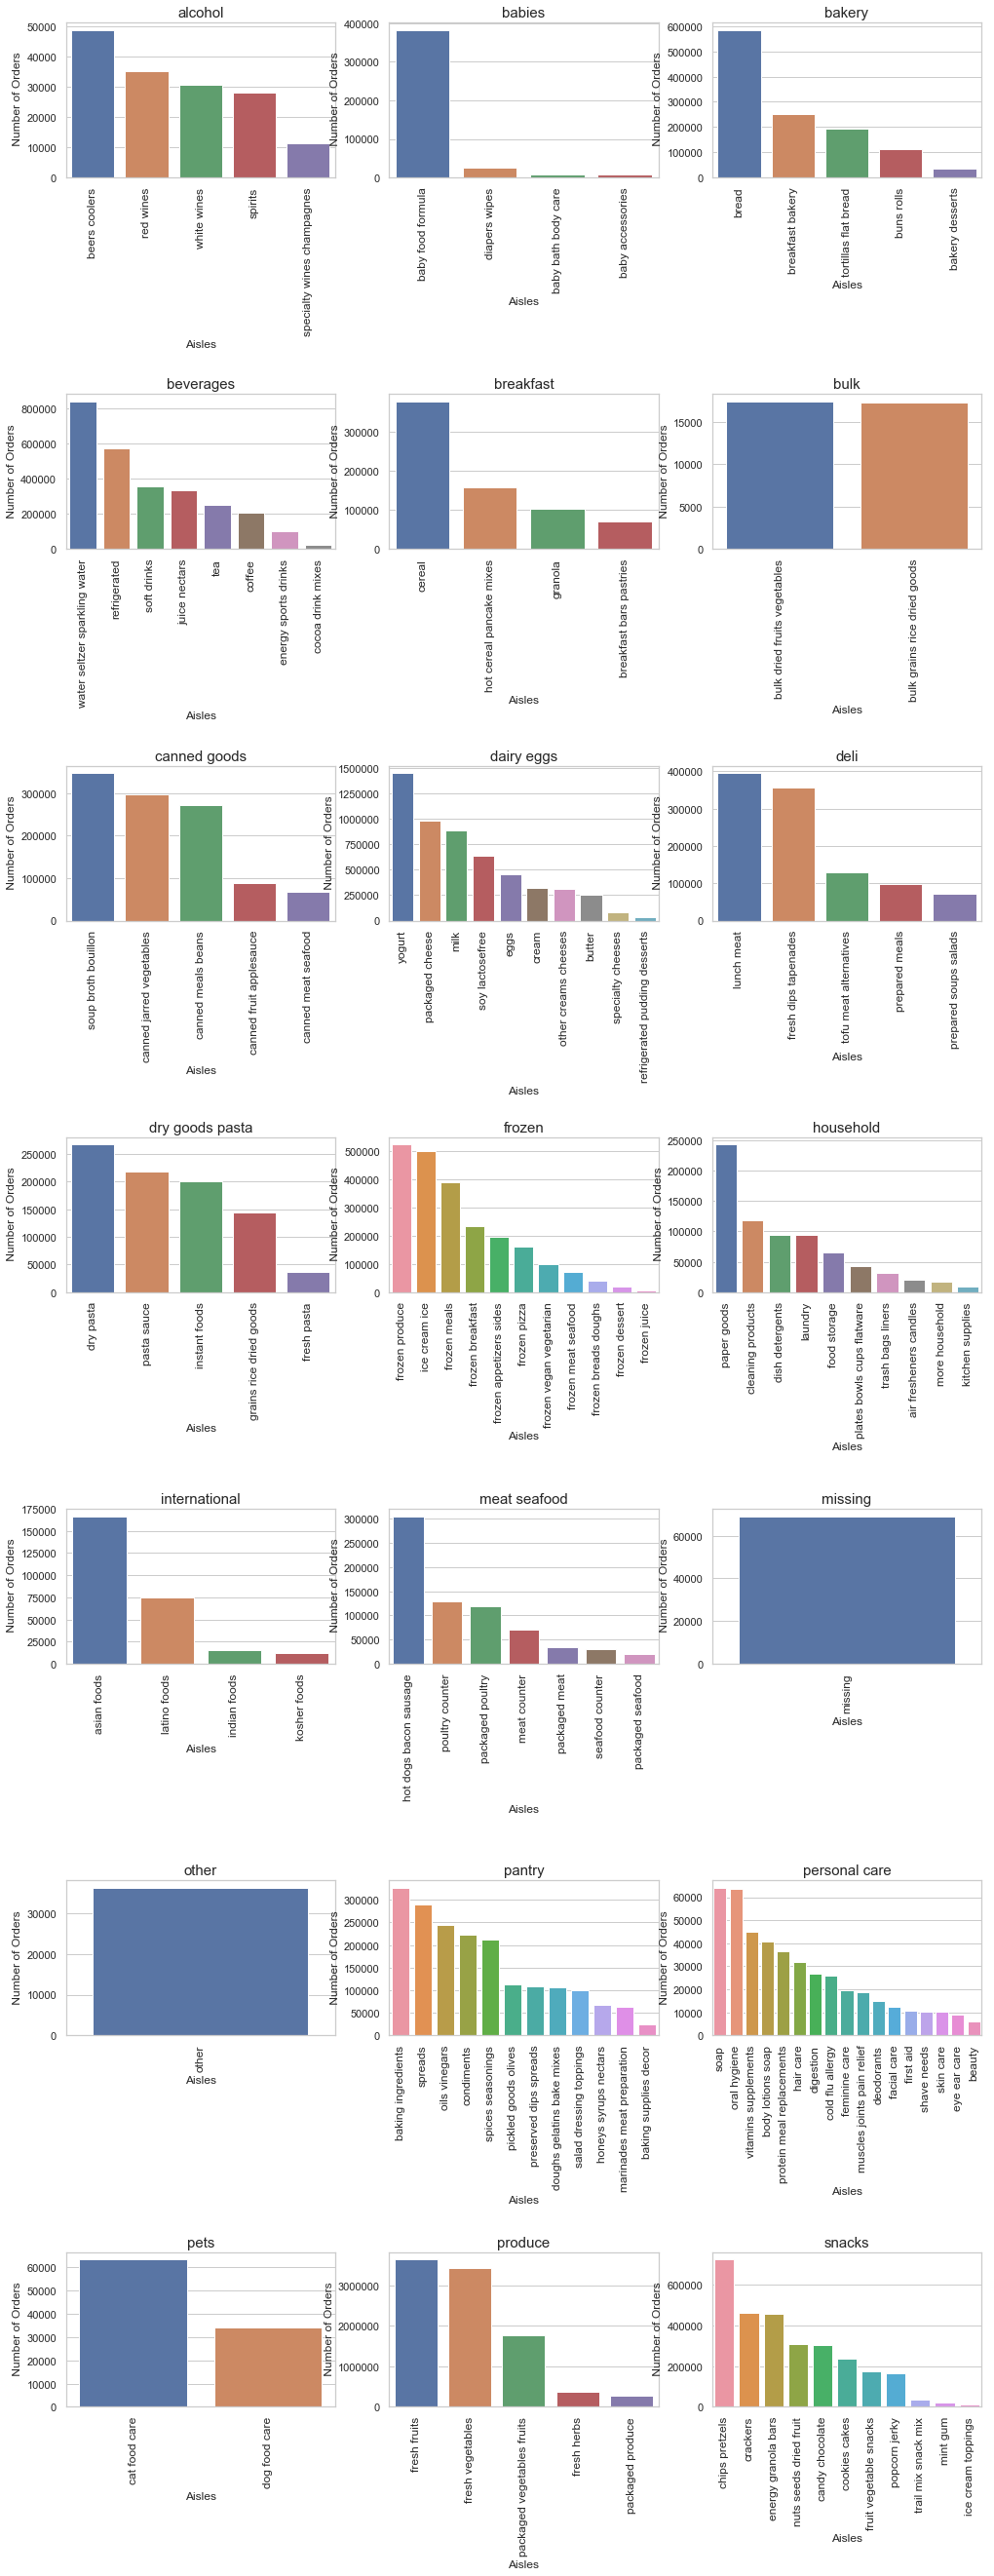

In [130]:
grouped = prior_data.groupby(["department", "aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(15,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

## Exploratory Data Analysis Findings Summary

**`add_to_cart_order`**:
- **The average number of items in a cart is about 8**
- **The minimum cart size is 1**
- **The maximum cart size is 145**
- **The median cart size is 6, which means that the data for this column is right skewed because the median is less than the mean**

**`reordered`:**
- **59% of the time products were reordered**

**`order_number`:**
- **The least number of orders a customer placed is 1**
- **The average customer placed 17 orders**
- **Half the customers placed less than 11 orders or less while the other half placed 11 orders or more**
- **the most number of orders placed by a customer is 100**
- **The distribution is slightly right skewed (mean > median)**

**`order_hour_of_day`:**
- **On average, orders were placed between 1-2 PM (13.43)**
- **Half the orders were placed on or before 1 PM, while the other half on or after 1 PM**

**`days_since_prior_order`**:
- **Because this feature is capped at 30 days, the maximum is 30**
- **Because customers can place more than one order a day, the minimum is 0**
- **On average, the previous order was placed roughly 11 days ago**
- **Half the orders were placed 8 or less days ago, while the other half were placed 8 or more days ago**

#### How Many Orders Do Customers Place?
- **Most customers placed around 4-7 Instacart orders. There seems to be a bump at 100 orders because the dataset is capped at 4-100 orders; hence, 100+ orders are lumped into the 100 orders category. The orginal orders dataset contains users with 4-100 orders.**
- **A majority of the customers had approximately 4 to 40 orders. The median seems to be located at 10 orders, and the spread (Q3-Q1) of the middle 50% of the data is about 15. There are a number of outliers displayed as individual points beyond the upper whisker of the boxplot.**

#### How Many Orders Do Customers Place by Day of Week?
- **There are more orders placed early on in the week (Sunday, Monday, and Tuesday). This may be because users shop for groceries for the rest of the week. The number of orders decreases into the middle of the week and increases again as the weekend approaches, which may be because working families have more time to cook on the weekends.**
- **There is more spread for Sunday and Monday, and the median number of orders fluctuates between 1500000 to 200000 across the different days of the week.**

#### How Many Orders Do Customers Place by Hour of Day?
- **The number of orders are the highest at 10 AM and 3 PM. Users tend to order around noon as indicated by the rounded top of the peak. This might be because users are purchasing already made salads for lunchtime and groceries before dinner time. Hence, we observe that users don't usually order during or after dinner hours. The number of orders start plummeting after 4 PM. We observe few orders before midnight and between midnight and 6AM because not a lot of stores open until midnight and most stores don't open until 6 AM**
- **The median number of orders increases throughout the day until 4 PM, peaking around the late morning (10 AM - 11 PM) to early afternoon hours (1-3 PM). The spread also increases with the median because there are more orders rolling in and therefore more variability in the data than late in the evening or during the wee hours.**

#### How Many Orders Do Customers Place by Day of Week vs. Hour of Day?
- **Most orders are placed between 10 AM - 4 PM on Sundays and 9 AM - 3 PM on Mondays. Customers also tend to place orders between 11 AM - 3 PM on Saturdays but at a lower frequency.**

#### How Many Items are in the Orders?
- **Most people, on average, have around 3-8 items in each transaction in both the prior and train datasets.**
- **The spread (Q3 - Q1 = ~10) of the middle 50% of the prior data is roughly the same as that of the train data. Both datasets are right skewed with a maximum of 145 (prior) and 80 (train) items in a single order. Most of the orders contain 1-30 products although there are quite a number of orders with more than 30 items displayed as outliers (individual points plotted beyond the upper whisker of the boxplot).**

#### How Many Items Do Customers Order by Day of Week?
- **This is consistent with what we have been seeing: there are more orders placed during Monday and the weekends. Hence, there should be more items purchased on these days of the week.**
- **Again, there's more spread for Sunday and Monday and the trend for the length of the boxplots across the days of the week mirror the heights of the above barplots.**

#### How Many Items Do Customers Order by Hour of Day?
- **The trend of the number of items purchased by hour of day is similar to that of the number of orders placed by hour of day. This is consistent with our intuition that the number of items purchased is directly proportional to the number of orders placed: the more orders placed, the more items purchased. However, the number of items purchased peak in the late afternoon for the train data as opposed to in the late morning in the prior data.**
- **By no surprise, the overall trend of the boxplots of number of items purchased by hour of the day for the prior and train dataset resembles that of the number of orders placed by hour of the day. Likewise, the amount of variation for the hour of the day increases when there are more items purchased. However, there is more spread in the prior dataset, which may be because it has more data. On the other hand, the train dataset has less spread and more frequent and extreme outliers.**

#### What Aisles are the Most Shopped at by Number of Orders?
- **A significant proportion of orders contain items from the fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, milk, and cheese aisles.**

#### What Aisles are the Most Shopped at by Number of Products?
- **Pretty much the same 15 aisles from which the most orders are purchased from is observed for the aisles from which a large proportion of products are purchased, with the exception of the eggs aisles which have been replaced by granola bars. This makes sense because eggs are often bought in packs of half or one dozen whereas singular granola bars can be purchased.**

#### What is the Size of the Departments?
- **The produce (29%), dairy eggs (17%), snacks (9%), beverages (8%), and frozen (7%) departments are the largest. Therefore, it is no surprise that more goods and orders are purchased from these departments' respective aisles.**

#### What Departments are the Most Shopped at by Number of Orders?
- **A large percentage of orders are purchased from the produce, dairy eggs, beverages, frozen, and pantry departments. A small percentage of orders are purchased from the alcohol, bulk, missing, other, and pets departments.**

#### What Departments are the Most Shopped at by Number of Products?
- **Most products are purchased from the produce, dairy eggs, beverages, frozen, and pantry departments. Customers buy products from the alcohol, bulk, missing, other, and pets departments the least. These are the same as the most popular and least popular departments when measuring by the number of orders.**

#### What Products Do Customers Order?
- **The majority of the top 15 most sold products are fruits and vegetables, which is verified by the most popular aisles, fresh fruits and fresh vegetables, and the department, produce. Something to note is that of the 15 most frequently bought products, 11 are organic! Let's dive deeper into organic products later.**

#### How Often Do Customers Reorder Items?
- **Of the prior dataset, 59% of the products are reordered, while 41% are not. For the train dataset, 60% of the products are reordered, while 40% are not.**

#### How Many Days Has It Been Before a Reorder?
- **Users tend to order in intervals of some multiple of 7 (7, 14, 21, or 28 days) or monthly (30 days).**

#### What Relationship Does the Number of Days Since the Last Order Have With The Probability of Reordering?
- **The number of days since the last order is capped from 0-30 days. The overall trend seems to be as more days pass by since the last order, the less likely customers will reorder. This is intuitive because if a customer doesn't like a product, interest for the product and the chances of reordering will fall as time pass. The longer since the last order, the more likely the customer won't reorder.**

#### What Relationship Does the Order of Items Placed in Cart Have With The Probability of Reordering?
- **The probability of an item being reordered decreases exponentially as its order added to the cart increases in a cart of size 1 to 50 items. After the 50 item mark, the trend is less coherent with sharp dips and rises. We observe a smoother trend for 1-50 items maybe because most orders don't have more than 50 items. Therefore, the curve of the average probability is smoothed out by the abundant data, whereas there is less data (maybe one or two orders with 9x items) as the order of items placed in cart increases. For example, if a product that was placed 90th in the cart was reordered, this information would greatly affect the average probability of 90th items being reordered.**

#### What are Reorder Behaviors by Day of Week?
- **Customers in the prior dataset reorder slightly more on Mondays and Fridays, while customers in the train dataset reorder more on Sundays and Fridays.**

#### What are Reorder Behaviors by Hour of Day?
- **Customers reorder more often during 6-9 AM than the other hours of the day. There is a smaller mode between 8-11 PM, most likely for a regular go-to late night snack or meal.**

#### What are Reorder Behaviors by Day of Week Vs Hour of Day?
- **Overall, customers tend to reorder during the early mornings (5-9 AM) rather than the later half of the day for all days of the week. There is some high frequency of reorders in the train dataset scattered in the wee hours up to 10 AM.**

#### What Aisles Do Customers Reorder From?
- **In the prior set, customers reorder most from the dairy and eggs, beverages, and produce aisles. In the train set, although at a small probability of 0.045, customers reorder most from the missing aisle. The next 14 most popular aisles reordered from are mainly produce, beverages, and dairy and eggs. Unlike in the prior set where all aisles contain items that are edible, two of the most popular aisles reordered from in the train set are cat food and paper goods.**
- **There are produce, dairy, frozen items, etc. in the missing aisle and department, and these goods were (re)ordered meaning that these aren't missing products. The missing aisle might be named so because the information for the aisle category is missing, and the products that should be allocated to other aisle categories are not.**

#### What Departments Do Customers Reorder From?
- **Customers mostly reorder goods from the dairy eggs, produce, beverages, bakery, pets, deli, and snacks departments. Personal care, pantry, and international are some of the least reordered departments.**

#### Which Items are Most Frequently Reordered?
- **Only items that were ordered more than 100 times were included because some items that are purchased very few times (ie, once) and reordered have very high probabilities of being reordered, which is not useful in helping us understand which items are bought and reordered frequently. For the prior set, the items most reordered are not in the train set, consisting of a variety of snacks, fruits, beverages, etc. The probabilities are much lower because that dataset includes more transactions than the train set. On the other hand, the items most frequently reordered in the train set are mostly dairy with some fruits and eggs.**
- **By just looking at the names, the 15 most reordered items in the prior set are pretty specific maybe because they do not have close substitutes or have strong brand loyalty; hence, the higher inclination for customers to repurchase those items. As for the train set, although most of the products are milk, there are many different variations: organic vs not organic, whole vs 2% vs 1%, etc. that have a similar effect as that of products with a few close substitutes.** 

#### How Often Do Customers Order Organic Items?
- **About 30% of the products are organic while 70% are not. This is reasonable because besides departments like produce and dairy and eggs, most departments like deli, bulk, and frozen don't provide organic options.**

#### How Often Do Customers Reorder Organic Items?
- **Although only a third of the products are organic, there is almost a 2/3 chance that an organic product will be reordered.**